## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.metrics import r2_score
import pickle

In [2]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/fit')
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/extract')
sys.path.insert(1, './params')
#from cper_bm_params_eval_plot_transect import *
#from cper_bm_params_eval_spatial_transect import *
#from cper_bm_params_eval_ecosite_transect import *
#from cper_bm_params_eval_year_transect import *
from cper_bm_params_eval_kmeans_transect import *

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import copy
from skorch import NeuralNetRegressor
import skorch
from dnn_setup import ResNetRegressor, ResidualBlock

## Define I/O

In [88]:
from importlib import reload
reload(sys.modules["cper_bm_params_eval_kmeans_transect"])
from cper_bm_params_eval_kmeans_transect import *

In [89]:
save_results = False
outDIR = './results'

## Load and pre-process data

In [90]:
with open(os.path.join(inDIR, 'ml_train_' + nickname + '_cv_' + kfold_group + '_tuneby_' + tuneby_group + '_results.pk'), 'rb') as f:
    mod_dict = pickle.load(f)
df = pd.read_csv(inPATH)
if 'transect' in inPATH:
    df['Plot'] = df[id_col].transform(lambda x: '_'.join(x.split('_')[:-1]))
elif 'plot' in inPATH:
    df['Plot'] = df[id_col]

In [91]:
if 'Plot' not in id_cols:
    id_cols = id_cols + ['Plot']
print(id_cols)

['Id', 'Plot', 'Pasture', 'Date_mean', 'Year', 'Season', 'Observed']


In [92]:
keep_cols = var_names + id_cols + [logo_group, y_col, date_col, past_col, id_col] + group_cols + list(mod_dict.keys())

In [93]:
drop_cols = [x for x in df.columns if x not in keep_cols]

In [94]:
drop_cols

['Date', 'Low', 'High', 'geometry', 'sqrt_Biomass_kg_ha', 'Kmeans']

In [95]:
def r_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    r = corr
    return r

In [96]:
df_bm_pred = pd.melt(df.drop(columns=drop_cols + var_names).rename(columns={y_col: 'Observed'}), 
                 id_vars=id_cols + [logo_group], 
                 value_name='Predicted',
                 var_name='Source')

In [97]:
[x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]

['Id', 'Plot', 'Pasture', 'Date_mean', 'Year', 'Season', 'Observed', 'kfold']

In [98]:
df_ens_lin = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR'])].drop(columns=['Source']).groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_lin['Source'] = 'ENS_LIN'

df_ens_ml = df_bm_pred[df_bm_pred['Source'].isin(
    ['SVR', 'RF', 'GBR', 'HGBR'])].drop(columns=['Source']).groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_ml['Source'] = 'ENS_ML'

df_ens_both = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'GBR', 'HGBR'])].drop(columns=['Source']).groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_both['Source'] = 'ENS_ALL'

In [99]:
df_bm_pred = pd.concat([df_bm_pred, df_ens_lin, df_ens_ml, df_ens_both])

In [100]:
for k in df_bm_pred['Source'].unique():
    if k in mod_dict.keys():
        if mod_dict[k]['xfrm_y'] is not None:
            df_bm_pred.loc[df_bm_pred['Source'] == k, 
            'Observed_xfrm'] = mod_dict[k]['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Observed'])
            df_bm_pred.loc[df_bm_pred['Source'] == k, 
            'Predicted_xfrm'] = mod_dict[k]['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Predicted'])
    else:
        df_bm_pred.loc[df_bm_pred['Source'] == k, 
        'Observed_xfrm'] = mod_dict['PLS']['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Observed'])
        df_bm_pred.loc[df_bm_pred['Source'] == k, 
        'Predicted_xfrm'] = mod_dict['PLS']['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Predicted'])

In [101]:
mods = ['CPER_2022', 'OLS_2022', 'OLS', 
        'LASSO', 'PLS', 'PCR', 
        'SVR', 'RF', 'GBR', 'HGBR', 'DNN',
        'ENS_LIN', 'ENS_ML', 'ENS_ALL']

In [102]:
df_bm_pred['Source'] = pd.Categorical(df_bm_pred['Source'], 
                                      categories=mods)

In [103]:
df_bm_pred['Source'] = df_bm_pred['Source'].cat.remove_unused_categories()

In [104]:
df_bm_pred[df_bm_pred['Source'].isnull()]

Empty DataFrame
Columns: [Id, Plot, Pasture, Date_mean, Year, Season, Observed, kfold, Source, Predicted, Observed_xfrm, Predicted_xfrm]
Index: []

In [105]:
df_bm_pred[df_bm_pred['Predicted_xfrm'].isnull()]#['Year'].unique()

Empty DataFrame
Columns: [Id, Plot, Pasture, Date_mean, Year, Season, Observed, kfold, Source, Predicted, Observed_xfrm, Predicted_xfrm]
Index: []

In [106]:
df_bm_pred

Id    Plot Pasture   Date_mean  Year   Season     Observed  kfold  \
0     10S_P1_1  10S_P1     10S  2014-06-12  2014     June  1280.282775      2   
1     31E_P4_1  31E_P4     31E  2014-06-12  2014     June  1557.012039      2   
2     31E_P3_4  31E_P3     31E  2014-06-12  2014     June   746.019804      1   
3     31E_P3_3  31E_P3     31E  2014-06-12  2014     June   717.349423      1   
4     31E_P3_2  31E_P3     31E  2014-06-12  2014     June  1288.316568      1   
...        ...     ...     ...         ...   ...      ...          ...    ...   
9642   CN_P4_4   CN_P4      CN  2021-10-18  2021  October   332.196029      0   
9643   CN_P4_4   CN_P4      CN  2022-06-13  2022     June   289.400595      0   
9644   CN_P4_4   CN_P4      CN  2022-10-05  2022  October     7.698318      0   
9645   CN_P4_4   CN_P4      CN  2023-06-22  2023     June   930.182632      2   
9646   CN_P4_4   CN_P4      CN  2023-10-19  2023  October   502.036020      0   

         Source    Predicted  Observed_xfrm  Predicted_xfrm  
0     CPER_2022  1614.799447       7.155617        7.387585  
1     CPER_2022   953.400493       7.351166        6.861083  
2     CPER_2022   812.821793       6.616092        6.701741  
3     CPER_2022   688.037089       6.576956        6.535295  
4     CPER_2022   693.749549       7.161868        6.543551  
...         ...          ...            ...             ...  
9642    ENS_ALL   774.175793      18.226246       27.824015  
9643    ENS_ALL   472.297239      17.011778       21.732401  
9644    ENS_ALL   385.591604       2.774584       19.636487  
9645    ENS_ALL  1192.883013      30.498896       34.538139  
9646    ENS_ALL   794.485467      22.406160       28.186619  

[115764 rows x 12 columns]

## Check disaggregated prediction

In [107]:
#df_bm_pred = df_bm_pred.groupby([mod_col, logo_group,  id_col, date_col] + group_cols).mean().reset_index().dropna()

In [108]:
mae_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs(x['Predicted_xfrm'] - x['Observed_xfrm'])), include_groups=False).round(4)
bias_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(x['Predicted_xfrm'] - x['Observed_xfrm']), include_groups=False).round(4)
mae_bt_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs(x['Predicted'] - x['Observed'])), include_groups=False).round(4)
r2_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    (lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm'])), include_groups=False).round(4)
r2_corr_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
        lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']), include_groups=False).round(4)

In [109]:
df_smry_obs = pd.DataFrame({
    'MAE': mae_obs.round(4),
    'Bias': bias_obs.round(4),
    'R^2': r2_obs.round(4),
    'r': r2_corr_obs.round(4),
    'MAE_bt': mae_bt_obs.round(4),
    'MAE_bt_pct': (mae_bt_obs / df_bm_pred[[mod_col, 'Observed']].groupby([mod_col], observed=True).mean()['Observed']).round(4),
})
display(df_smry_obs)

MAE    Bias     R^2       r    MAE_bt  MAE_bt_pct
Source                                                         
CPER_2022  0.3563  0.0274  0.4957  0.7055  286.5450      0.3350
OLS_2022   4.6449 -0.3156  0.5239  0.7264  276.1675      0.3229
OLS        4.7753  0.9740  0.4864  0.7155  289.0909      0.3380
LASSO      4.6824  0.5702  0.5227  0.7326  275.8889      0.3226
PLS        4.3644 -0.2828  0.5767  0.7643  261.4426      0.3057
PCR        4.3088  0.0154  0.5835  0.7644  259.4781      0.3034
SVR        4.3842 -0.2167  0.5682  0.7564  261.3533      0.3056
RF         4.9904  0.5969  0.4526  0.6789  298.8996      0.3495
HGBR       4.6971  0.3358  0.5092  0.7148  281.4137      0.3290
ENS_LIN    4.3484  0.1396  0.5781  0.7606  260.8599      0.3050
ENS_ML     4.5831  0.2704  0.5343  0.7319  273.5639      0.3199
ENS_ALL    4.4208  0.2182  0.5654  0.7530  264.4403      0.3092

In [110]:
max_lim = max(df_bm_pred[['Observed', 'Predicted']].max())*1.1
max_lim_xfrm = max(df_bm_pred[['Observed_xfrm', 'Predicted_xfrm']].max())*1.1

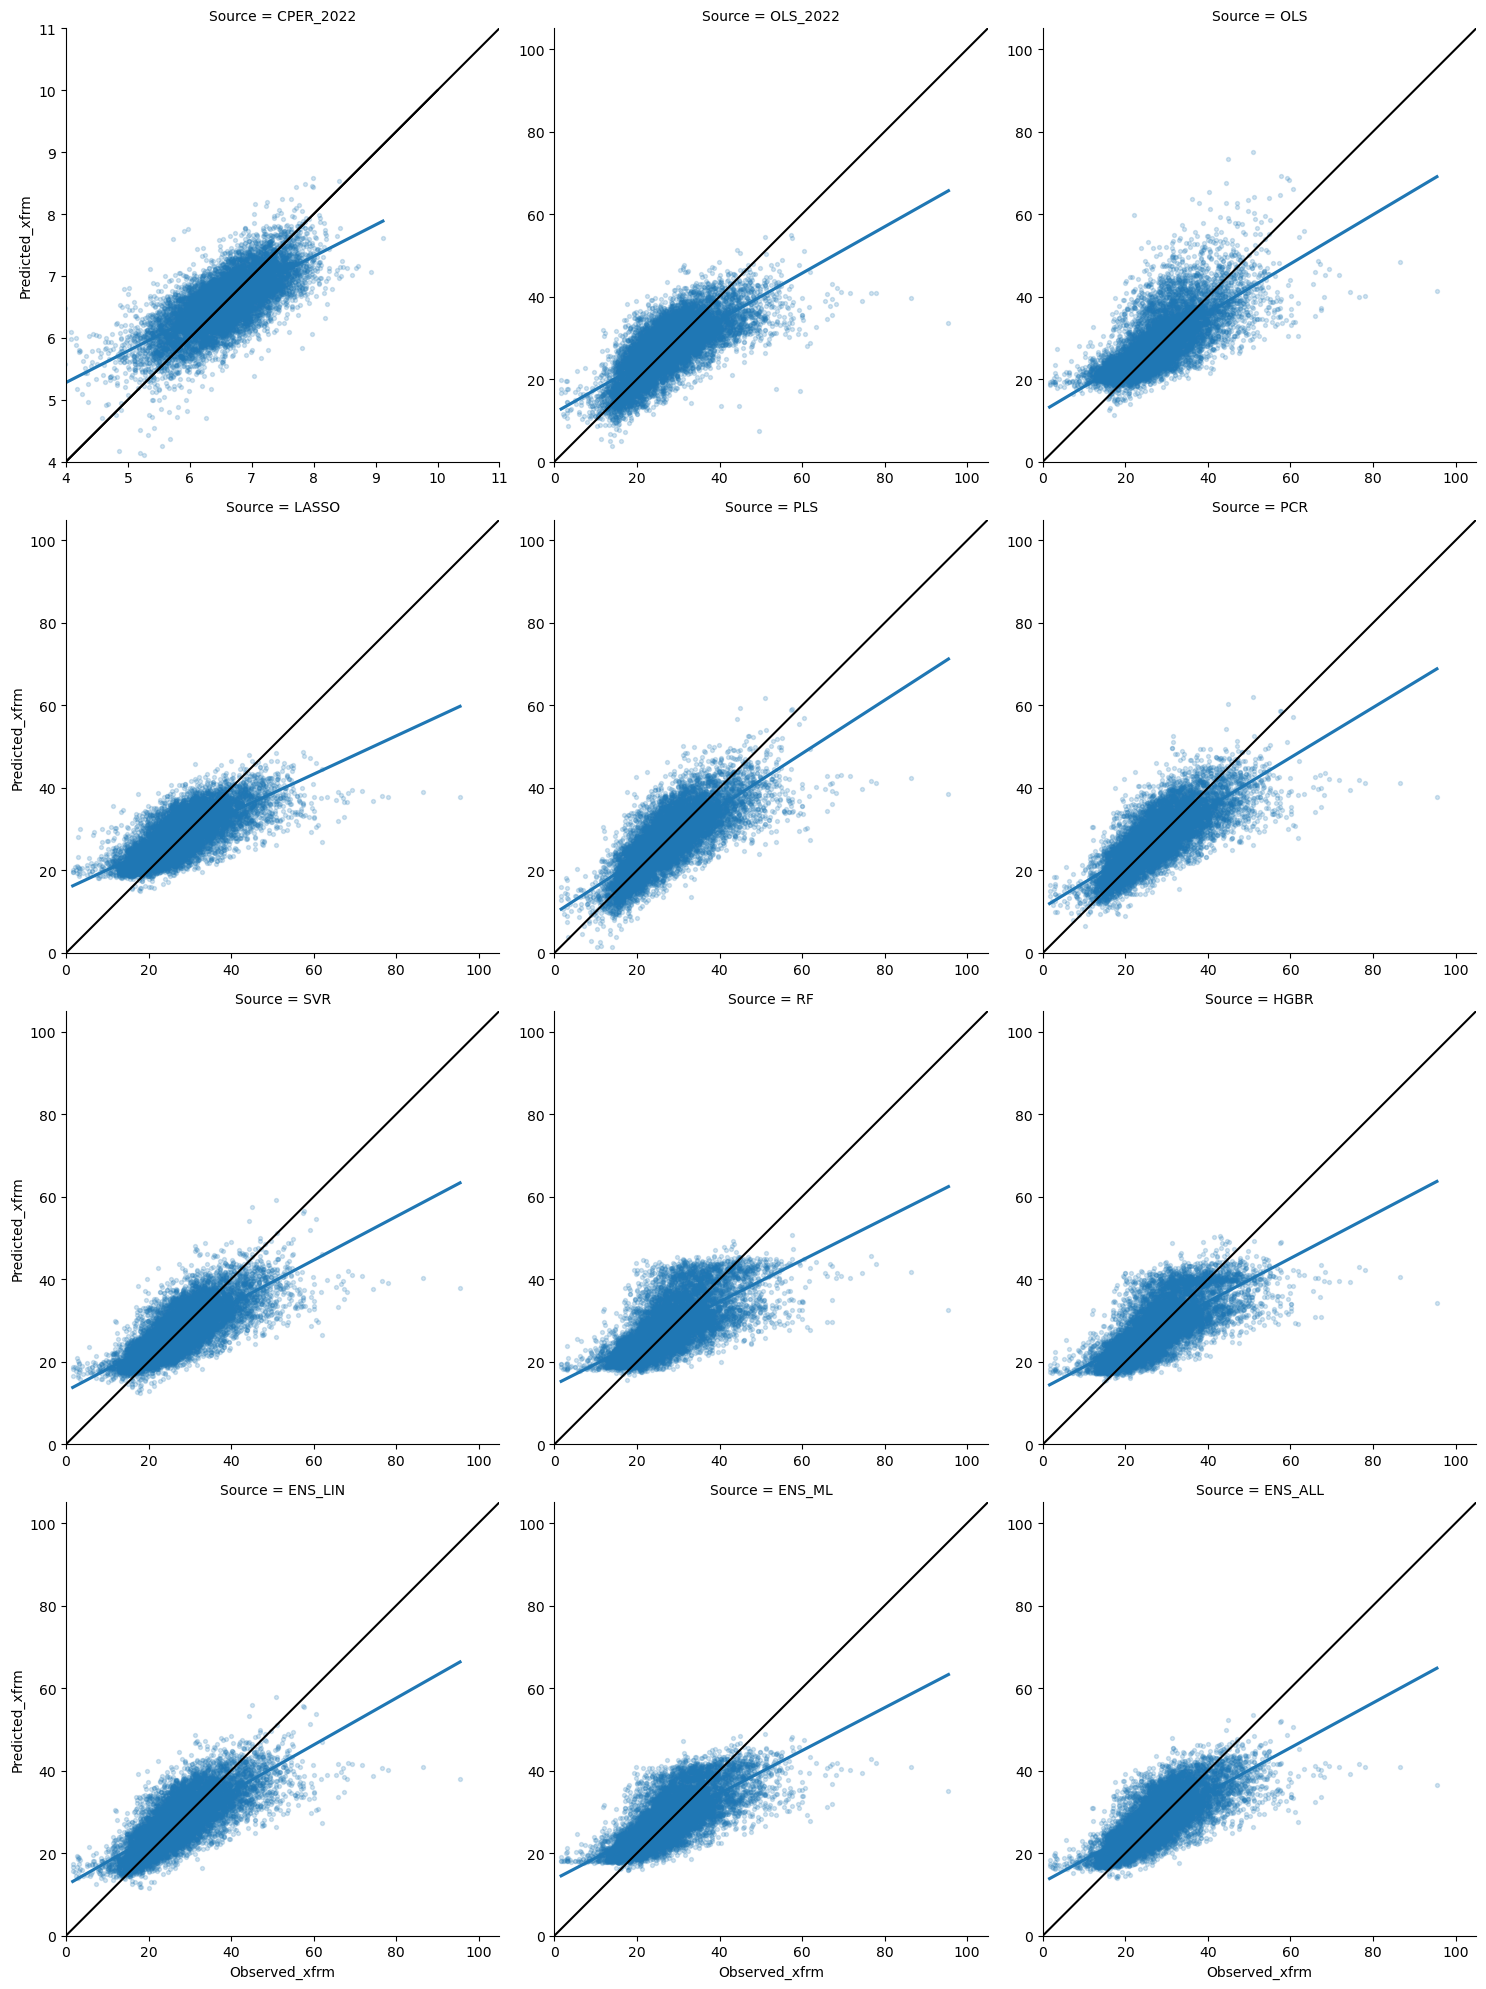

In [111]:
p_obs = sns.lmplot(df_bm_pred,
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3, ci=None,
                   facet_kws=dict(sharey=False, sharex=False,),
                    scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
for ax in p_obs.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.set_xlim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_obs.axes[0].set_ylim((4, 11))
p_obs.axes[0].set_xlim((4, 11))
p_obs.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')

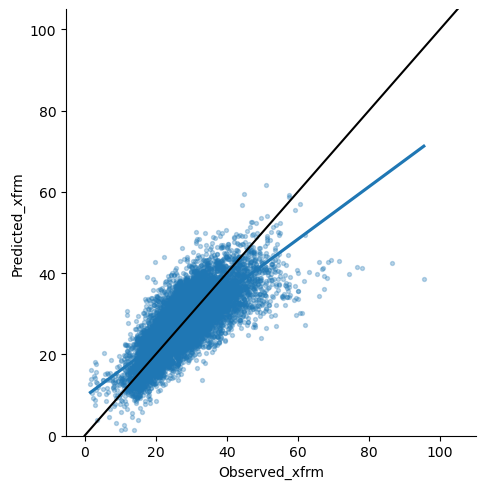

In [112]:
p_obs_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'PLS'],
               x='Observed_xfrm', y='Predicted_xfrm', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.3, 'edgecolor': None})
for ax in p_obs_best.axes.flatten():
        ax.set_ylim((0, max_lim_xfrm))
        ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')

## Get aggregated predictions

### Transect

MAE  MAE_std    Bias  Bias_std     R^2  R^2_std       r   r_std  \
Source                                                                          
CPER_2022  0.3543   0.0460  0.0204    0.2254  0.1276   0.1440  0.5655  0.1158   
OLS_2022   4.7745   0.8375 -0.3731    2.7052  0.1654   0.2167  0.5781  0.0720   
OLS        4.9997   1.8106  1.2038    3.2152  0.1365   0.2999  0.5691  0.1138   
LASSO      4.7884   0.6792  0.4132    2.5651  0.1537   0.2244  0.5531  0.1224   
PLS        4.5091   0.9699 -0.2076    1.9713  0.2776   0.1028  0.6141  0.0351   
PCR        4.4508   0.9599  0.0265    1.9209  0.2902   0.1091  0.6152  0.0340   
SVR        4.5081   0.8449 -0.2816    2.1298  0.2665   0.0666  0.6018  0.0494   
RF         5.2101   1.3588  0.5382    3.6876  0.0644   0.1872  0.5450  0.1051   
HGBR       4.8770   1.1648  0.2618    2.8060  0.1664   0.1229  0.5550  0.0985   
ENS_LIN    4.4868   0.9286  0.1126    2.0274  0.2789   0.1055  0.6078  0.0381   
ENS_ML     4.7529   1.0791  0.2069    2.8310  0.2052   0.1203  0.5914  0.0749   
ENS_ALL    4.5718   0.9721  0.1738    2.4012  0.2577   0.0954  0.6088  0.0507   

             MAE_bt  MAE_bt_std  MAE_bt_pct  MAE_bt_pct_std  Bias_bt  \
Source                                                                 
CPER_2022  302.1198    113.4922      0.3422          0.0305 -57.7465   
OLS_2022   291.8375    107.4914      0.3313          0.0402 -55.3674   
OLS        313.6264    180.7010      0.3476          0.0986  49.7021   
LASSO      290.4672     99.2424      0.3367          0.0591 -25.8790   
PLS        277.9845    116.0824      0.3102          0.0250 -35.8874   
PCR        275.5679    113.4634      0.3075          0.0222 -29.2703   
SVR        276.4938    108.3882      0.3116          0.0283 -57.7706   
RF         321.3832    145.4643      0.3589          0.0538  -4.6906   
HGBR       300.9487    131.7168      0.3363          0.0426 -23.0752   
ENS_LIN    276.7156    111.7996      0.3096          0.0222 -30.3456   
ENS_ML     292.1685    124.4044      0.3277          0.0411 -28.5121   
ENS_ALL    281.4041    116.1759      0.3152          0.0288 -29.4289   

           Bias_bt_std  
Source                  
CPER_2022     217.0816  
OLS_2022      169.2859  
OLS           223.6189  
LASSO         153.9673  
PLS           126.9000  
PCR           126.6493  
SVR           133.5924  
RF            233.9941  
HGBR          177.1830  
ENS_LIN       130.5163  
ENS_ML        177.7968  
ENS_ALL       152.5682

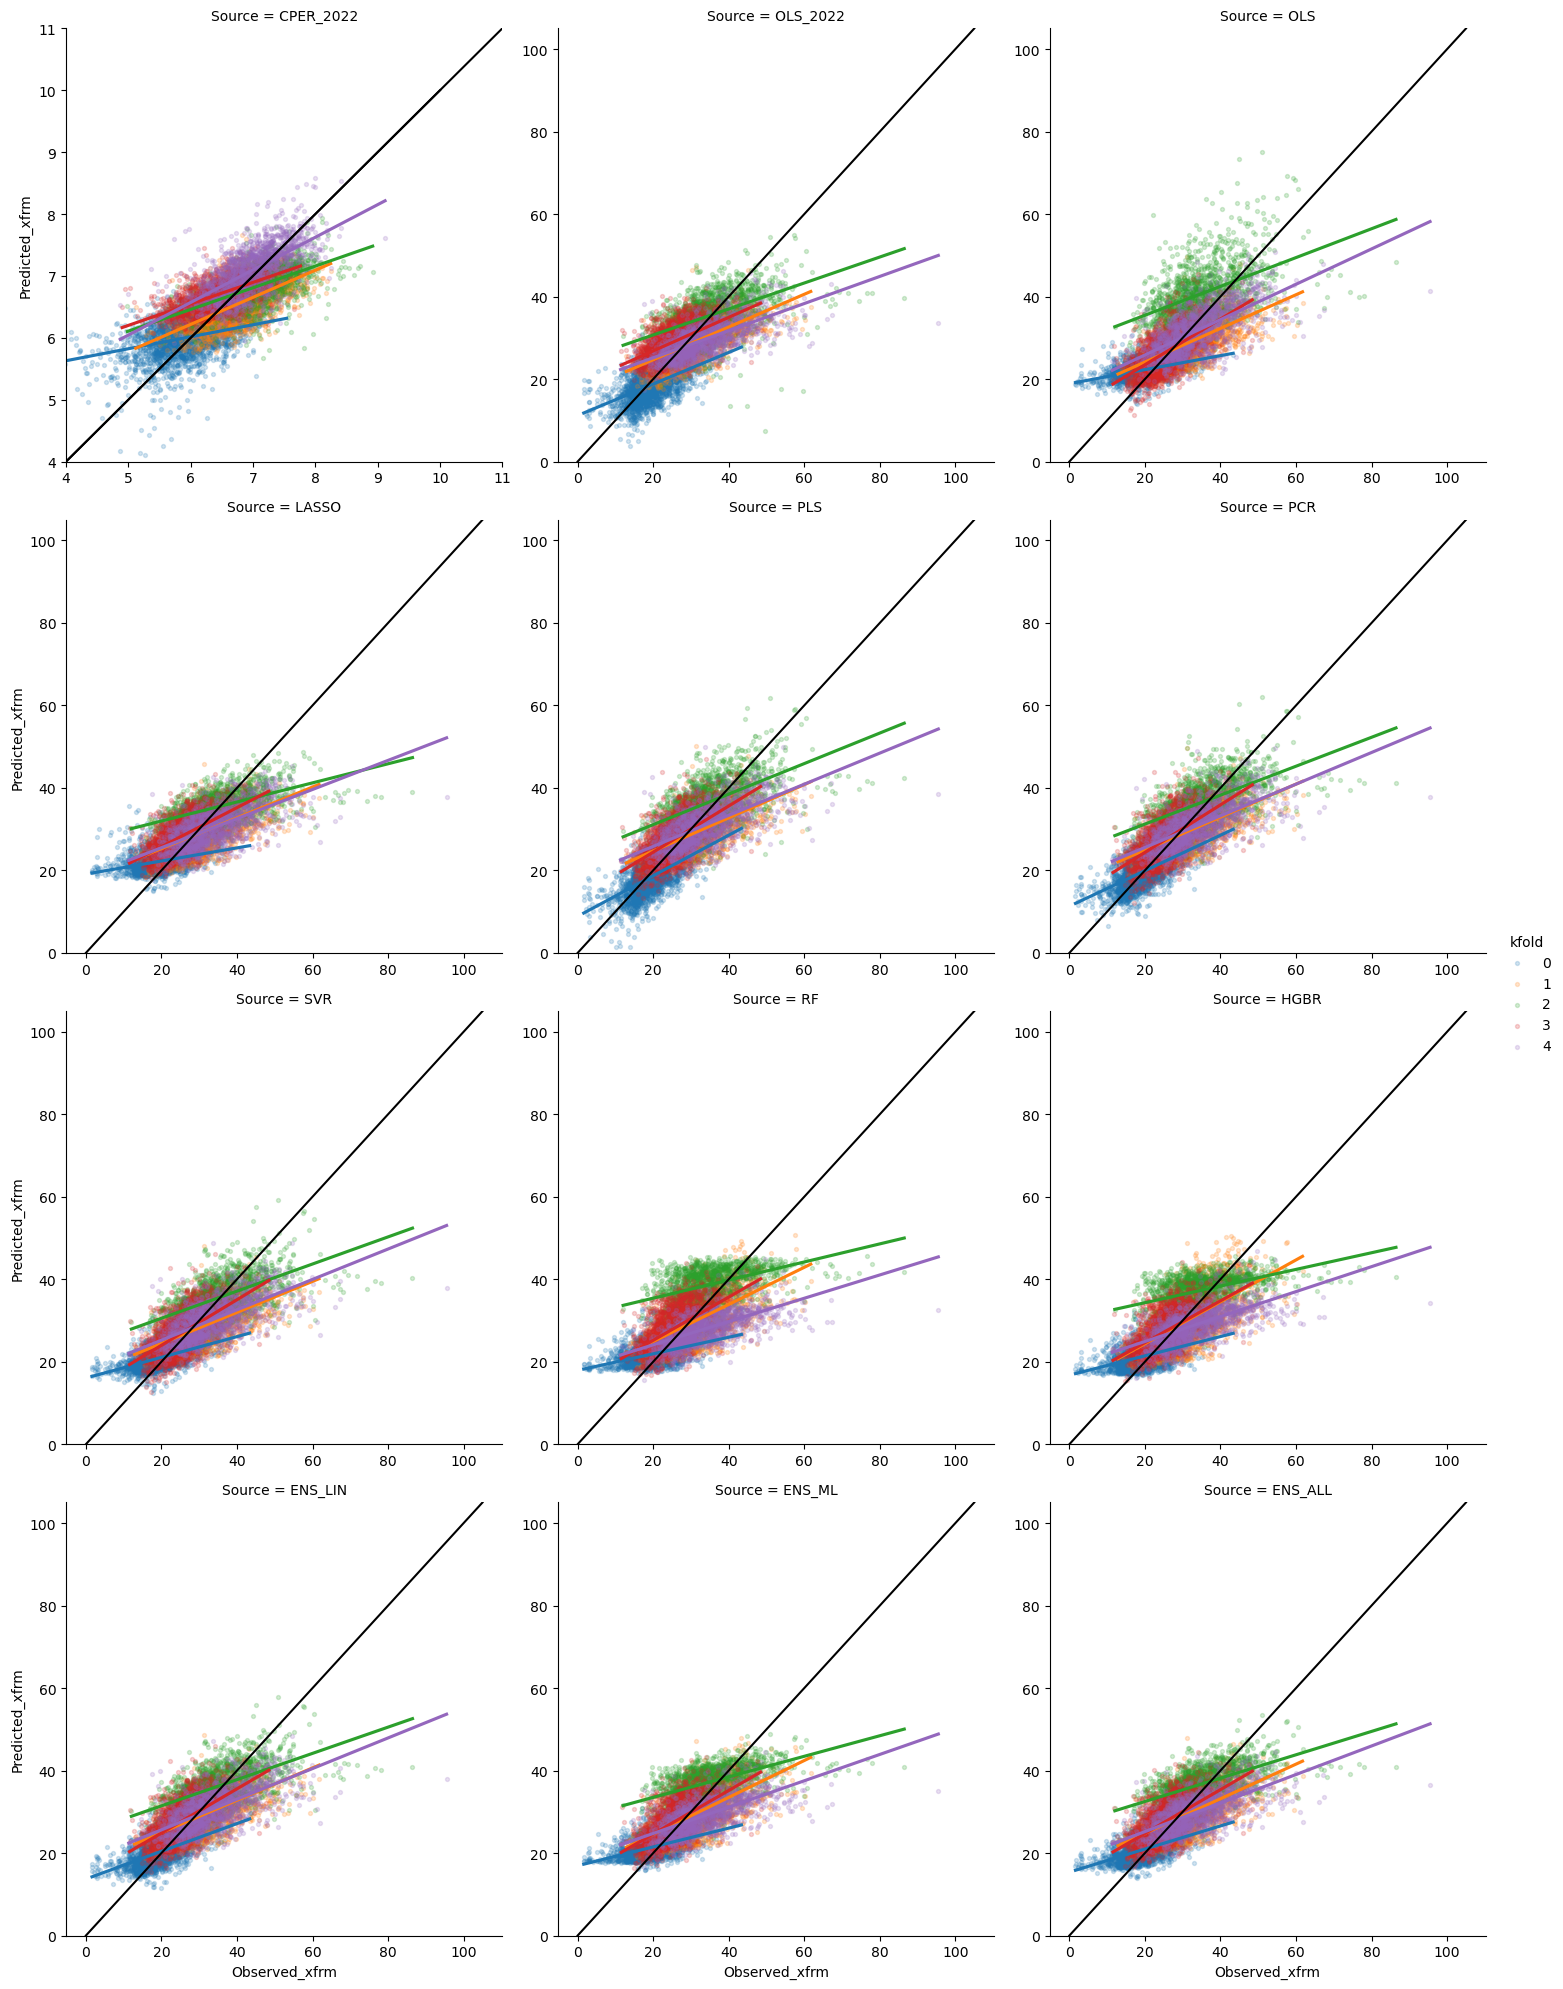

In [113]:
if 'transect' in inPATH:
    mae_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])), 
            include_groups=False).mean(), include_groups=False).round(4)
    bias_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
            include_groups=False).mean(), include_groups=False).round(4)
    mae_bt_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
            include_groups=False).mean(), include_groups=False).round(4)
    bias_bt_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
            include_groups=False).mean(), include_groups=False).round(4)
    r2_transect = df_bm_pred.groupby([mod_col, logo_group, id_col, date_col], 
                                 observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
        [mod_col, logo_group], observed=True).apply(
        lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
        include_groups=False).round(4)
    r2_corr_transect = df_bm_pred.groupby([mod_col, logo_group, id_col, past_col, date_col], 
                                 observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
        [mod_col, logo_group], observed=True).apply(
            lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
        include_groups=False).round(4)

    df_smry_transect = pd.DataFrame({
        'MAE': mae_transect.unstack(level=0).mean().round(4),
        'MAE_std': mae_transect.unstack(level=0).std().round(4),
        'Bias': bias_transect.unstack(level=0).mean().round(4),
        'Bias_std': bias_transect.unstack(level=0).std().round(4),
        'R^2': r2_transect.unstack(level=0).mean().round(4),
        'R^2_std': r2_transect.unstack(level=0).std().round(4),
        'r': r2_corr_transect.unstack(level=0).mean().round(4),
        'r_std': r2_corr_transect.unstack(level=0).std().round(4),
        'MAE_bt': mae_bt_transect.unstack(level=0).mean().round(4),
        'MAE_bt_std': mae_bt_transect.unstack(level=0).std().round(4),
        'MAE_bt_pct': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], 
                                                        observed=True)['Observed'].mean()).unstack(level=0).mean().round(4),
        'MAE_bt_pct_std': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], 
                                                        observed=True)['Observed'].mean()).unstack(level=0).std().round(4),
        'Bias_bt': bias_bt_transect.unstack(level=0).mean().round(4),
        'Bias_bt_std': bias_bt_transect.unstack(level=0).std().round(4),
    })
    display(df_smry_transect)
    if save_results:
        df_smry_transect.to_csv(os.path.join(outDIR,
                                             'tables/ml_models', 
                                             re.sub('tmp.csv', 'results_transect.csv', os.path.basename(inPATH))))
    
    df_smry_transect_by_yr = pd.DataFrame({
        'MAE': mae_transect.round(4),
        'Bias': bias_transect.round(4),
        'MAE_bt': mae_bt_transect.round(4),
        'MAE_pct': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], observed=True)['Observed'].mean()).round(4),
        'R^2': r2_transect.round(4),
        'r': r2_corr_transect.round(4)
    })
    #display(df_smry_transect_by_yr)
    if save_results:
        df_smry_transect_by_yr.to_csv(os.path.join(outDIR,
                                                   'tables/ml_models', 
                                                   re.sub('tmp.csv', 'results_transect_yrly.csv', os.path.basename(inPATH))))

    p_transect = sns.lmplot(df_bm_pred.groupby([mod_col, logo_group, id_col, date_col], 
                                           observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
                   x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                        facet_kws=dict(sharey=False, sharex=False,),
                        hue=logo_group, ci=None,
                        scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
    for ax in p_transect.axes:
        ax.set_ylim((0, max_lim_xfrm))
        ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
    p_transect.axes[0].set_ylim((4, 11))
    p_transect.axes[0].set_xlim((4, 11))
    p_transect.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
    if save_results:
        plt.savefig(os.path.join(outDIR, 
                                 'figures/ml_models',
                                 re.sub('tmp.csv', 'results_transect.png', os.path.basename(inPATH))), dpi=100)

### Plot

In [114]:
mae_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])), 
        include_groups=False).mean(), include_groups=False).round(4)
bias_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
        include_groups=False).mean(), include_groups=False).round(4)
mae_bt_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
        include_groups=False).mean(), include_groups=False).round(4)
bias_bt_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
        include_groups=False).mean(), include_groups=False).round(4)
r2_plot = df_bm_pred.groupby([mod_col, logo_group, 'Plot', date_col], 
                             observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
    [mod_col, logo_group], observed=True).apply(
    lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
    include_groups=False).round(4)
r2_corr_plot = df_bm_pred.groupby([mod_col, logo_group, 'Plot', past_col, date_col], 
                             observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
    [mod_col, logo_group], observed=True).apply(
        lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
    include_groups=False).round(4)

In [115]:
df_smry_plot = pd.DataFrame({
    'MAE': mae_plot.unstack(level=0).mean().round(4),
    'MAE_std': mae_plot.unstack(level=0).std().round(4),
    'Bias': bias_plot.unstack(level=0).mean().round(4),
    'Bias_std': bias_plot.unstack(level=0).std().round(4),
    'R^2': r2_plot.unstack(level=0).mean().round(4),
    'R^2_std': r2_plot.unstack(level=0).std().round(4),
    'r': r2_corr_plot.unstack(level=0).mean().round(4),
    'r_std': r2_corr_plot.unstack(level=0).std().round(4),
    'MAE_bt': mae_bt_plot.unstack(level=0).mean().round(4),
    'MAE_bt_std': mae_bt_plot.unstack(level=0).std().round(4),
    'MAE_bt_pct': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).mean().round(4),
    'MAE_bt_pct_std': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).std().round(4),
    'Bias_bt': bias_bt_plot.unstack(level=0).mean().round(4),
    'Bias_bt_std': bias_bt_plot.unstack(level=0).std().round(4),
})
display(df_smry_plot)
if save_results:
    df_smry_plot.to_csv(os.path.join(outDIR,
                                     'tables/ml_models', 
                                     re.sub('tmp.csv', 'results_plot.csv', os.path.basename(inPATH))))

df_smry_plot_by_yr = pd.DataFrame({
    'MAE': mae_plot.round(4),
    'Bias': bias_plot.round(4),
    'MAE_bt': mae_bt_plot.round(4),
    'MAE_pct': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], observed=True)['Observed'].mean()).round(4),
    'R^2': r2_plot.round(4),
    'r': r2_corr_plot.round(4)
})
#display(df_smry_plot_by_yr)
if save_results:
    df_smry_plot_by_yr.to_csv(os.path.join(outDIR, 
                                           'tables/ml_models', 
                                           re.sub('tmp.csv', 'results_plot_yrly.csv', os.path.basename(inPATH))))

MAE  MAE_std    Bias  Bias_std     R^2  R^2_std       r   r_std  \
Source                                                                          
CPER_2022  0.3082   0.0467  0.0205    0.2254  0.1241   0.1996  0.6238  0.1305   
OLS_2022   4.0675   0.7184 -0.3715    2.7053  0.1778   0.3070  0.6409  0.0797   
OLS        4.2328   1.7324  1.2069    3.2198  0.1611   0.3673  0.6380  0.1215   
LASSO      4.0180   0.5193  0.4157    2.5665  0.1693   0.2890  0.6174  0.1363   
PLS        3.7121   0.8006 -0.2058    1.9721  0.3424   0.1401  0.6860  0.0343   
PCR        3.6486   0.7959  0.0288    1.9223  0.3533   0.1492  0.6872  0.0344   
SVR        3.7321   0.6670 -0.2795    2.1312  0.3154   0.0912  0.6702  0.0525   
RF         4.4422   1.2941  0.5422    3.6913  0.0681   0.2556  0.6229  0.1138   
HGBR       4.0582   1.0442  0.2657    2.8094  0.2054   0.1713  0.6294  0.1085   
ENS_LIN    3.6946   0.7403  0.1148    2.0287  0.3316   0.1467  0.6773  0.0402   
ENS_ML     3.9610   0.9500  0.2103    2.8339  0.2381   0.1647  0.6642  0.0822   
ENS_ALL    3.7802   0.7961  0.1766    2.4033  0.3022   0.1313  0.6798  0.0554   

             MAE_bt  MAE_bt_std  MAE_bt_pct  MAE_bt_pct_std  Bias_bt  \
Source                                                                 
CPER_2022  264.2528    100.8205      0.2995          0.0307 -57.6368   
OLS_2022   249.9137     90.1837      0.2853          0.0429 -55.2735   
OLS        265.9840    163.0135      0.2946          0.0962  49.9156   
LASSO      244.0337     79.6450      0.2854          0.0584 -25.7364   
PLS        230.9868     95.8159      0.2580          0.0226 -35.7812   
PCR        227.9494     93.7888      0.2544          0.0214 -29.1350   
SVR        231.0297     89.8182      0.2608          0.0259 -57.6450   
RF         274.4390    130.6840      0.3058          0.0572  -4.4357   
HGBR       251.5925    114.7142      0.2808          0.0452 -22.8371   
ENS_LIN    229.4291     91.6269      0.2572          0.0215 -30.2175   
ENS_ML     244.4657    107.0026      0.2743          0.0427 -28.3059   
ENS_ALL    233.9054     96.8290      0.2624          0.0289 -29.2617   

           Bias_bt_std  
Source                  
CPER_2022     216.9623  
OLS_2022      169.3054  
OLS           223.9909  
LASSO         154.0010  
PLS           126.9810  
PCR           126.7477  
SVR           133.6542  
RF            234.2577  
HGBR          177.3829  
ENS_LIN       130.5887  
ENS_ML        177.9715  
ENS_ALL       152.6909

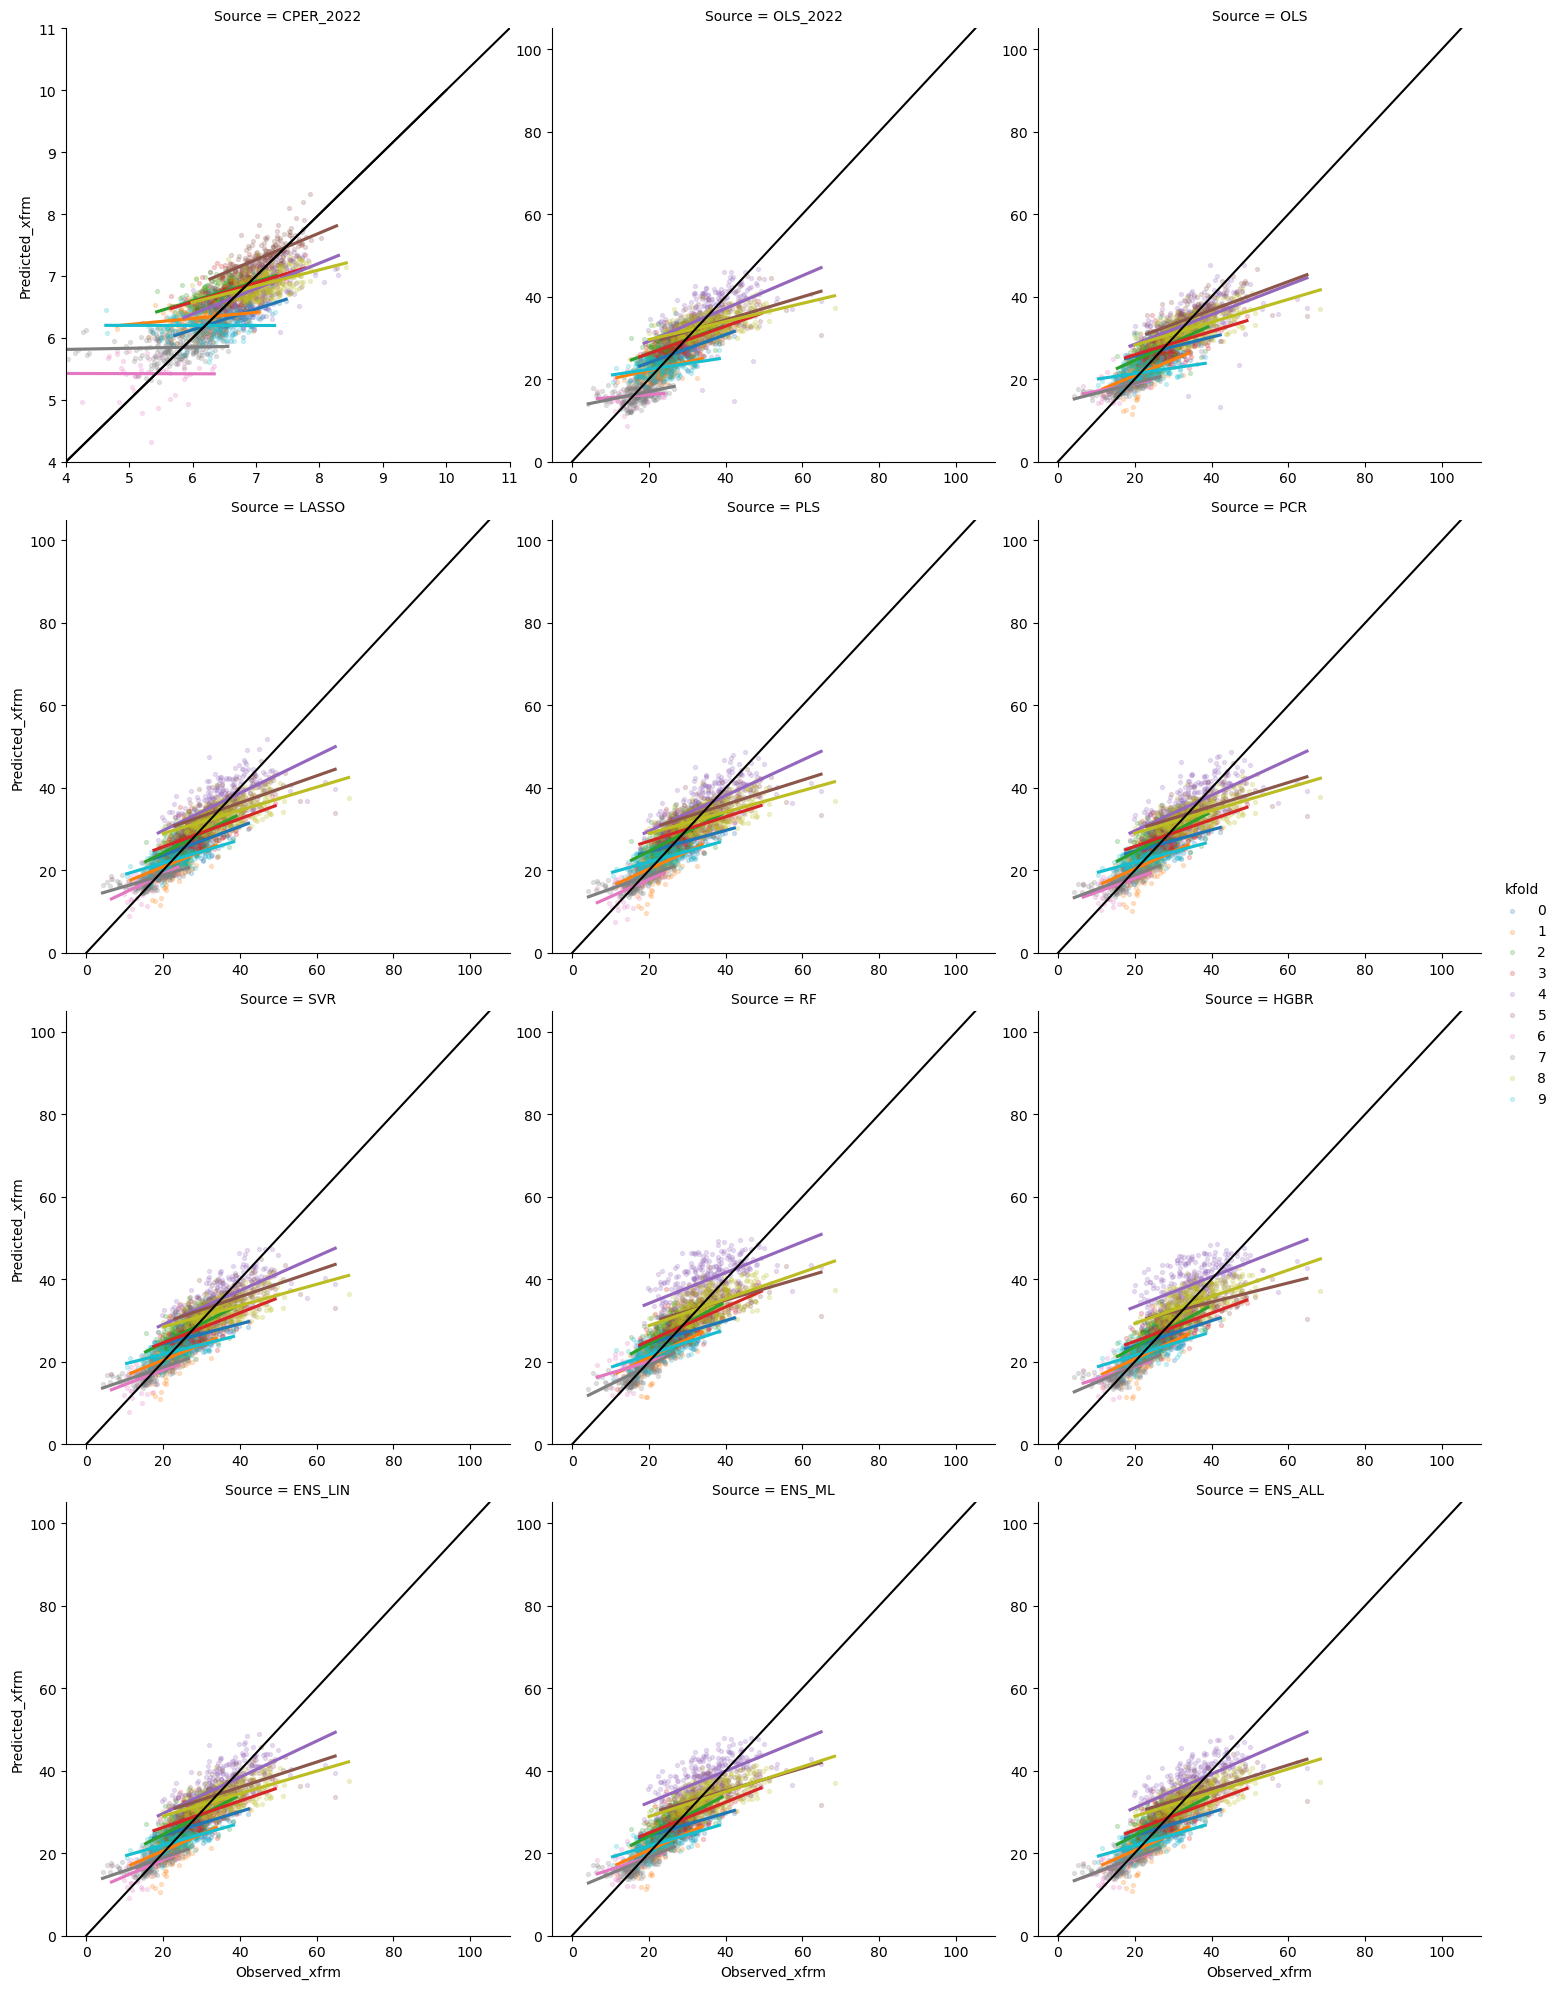

In [101]:
p_plot = sns.lmplot(df_bm_pred.groupby([mod_col, logo_group, 'Plot', date_col], 
                                       observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                    facet_kws=dict(sharey=False, sharex=False,),
                    hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
for ax in p_plot.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_plot.axes[0].set_ylim((4, 11))
p_plot.axes[0].set_xlim((4, 11))
p_plot.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 
                             'figures/ml_models', 
                             re.sub('tmp.csv', 'results_plot.png', os.path.basename(inPATH))), dpi=100)

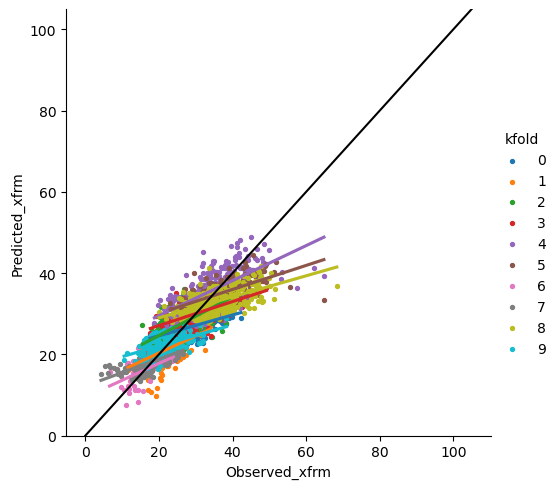

In [102]:
p_plot_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'PLS'].groupby([logo_group, 'Plot', date_col], 
                                       observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', ci=None, hue=logo_group,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_plot_best.axes.flatten():
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')

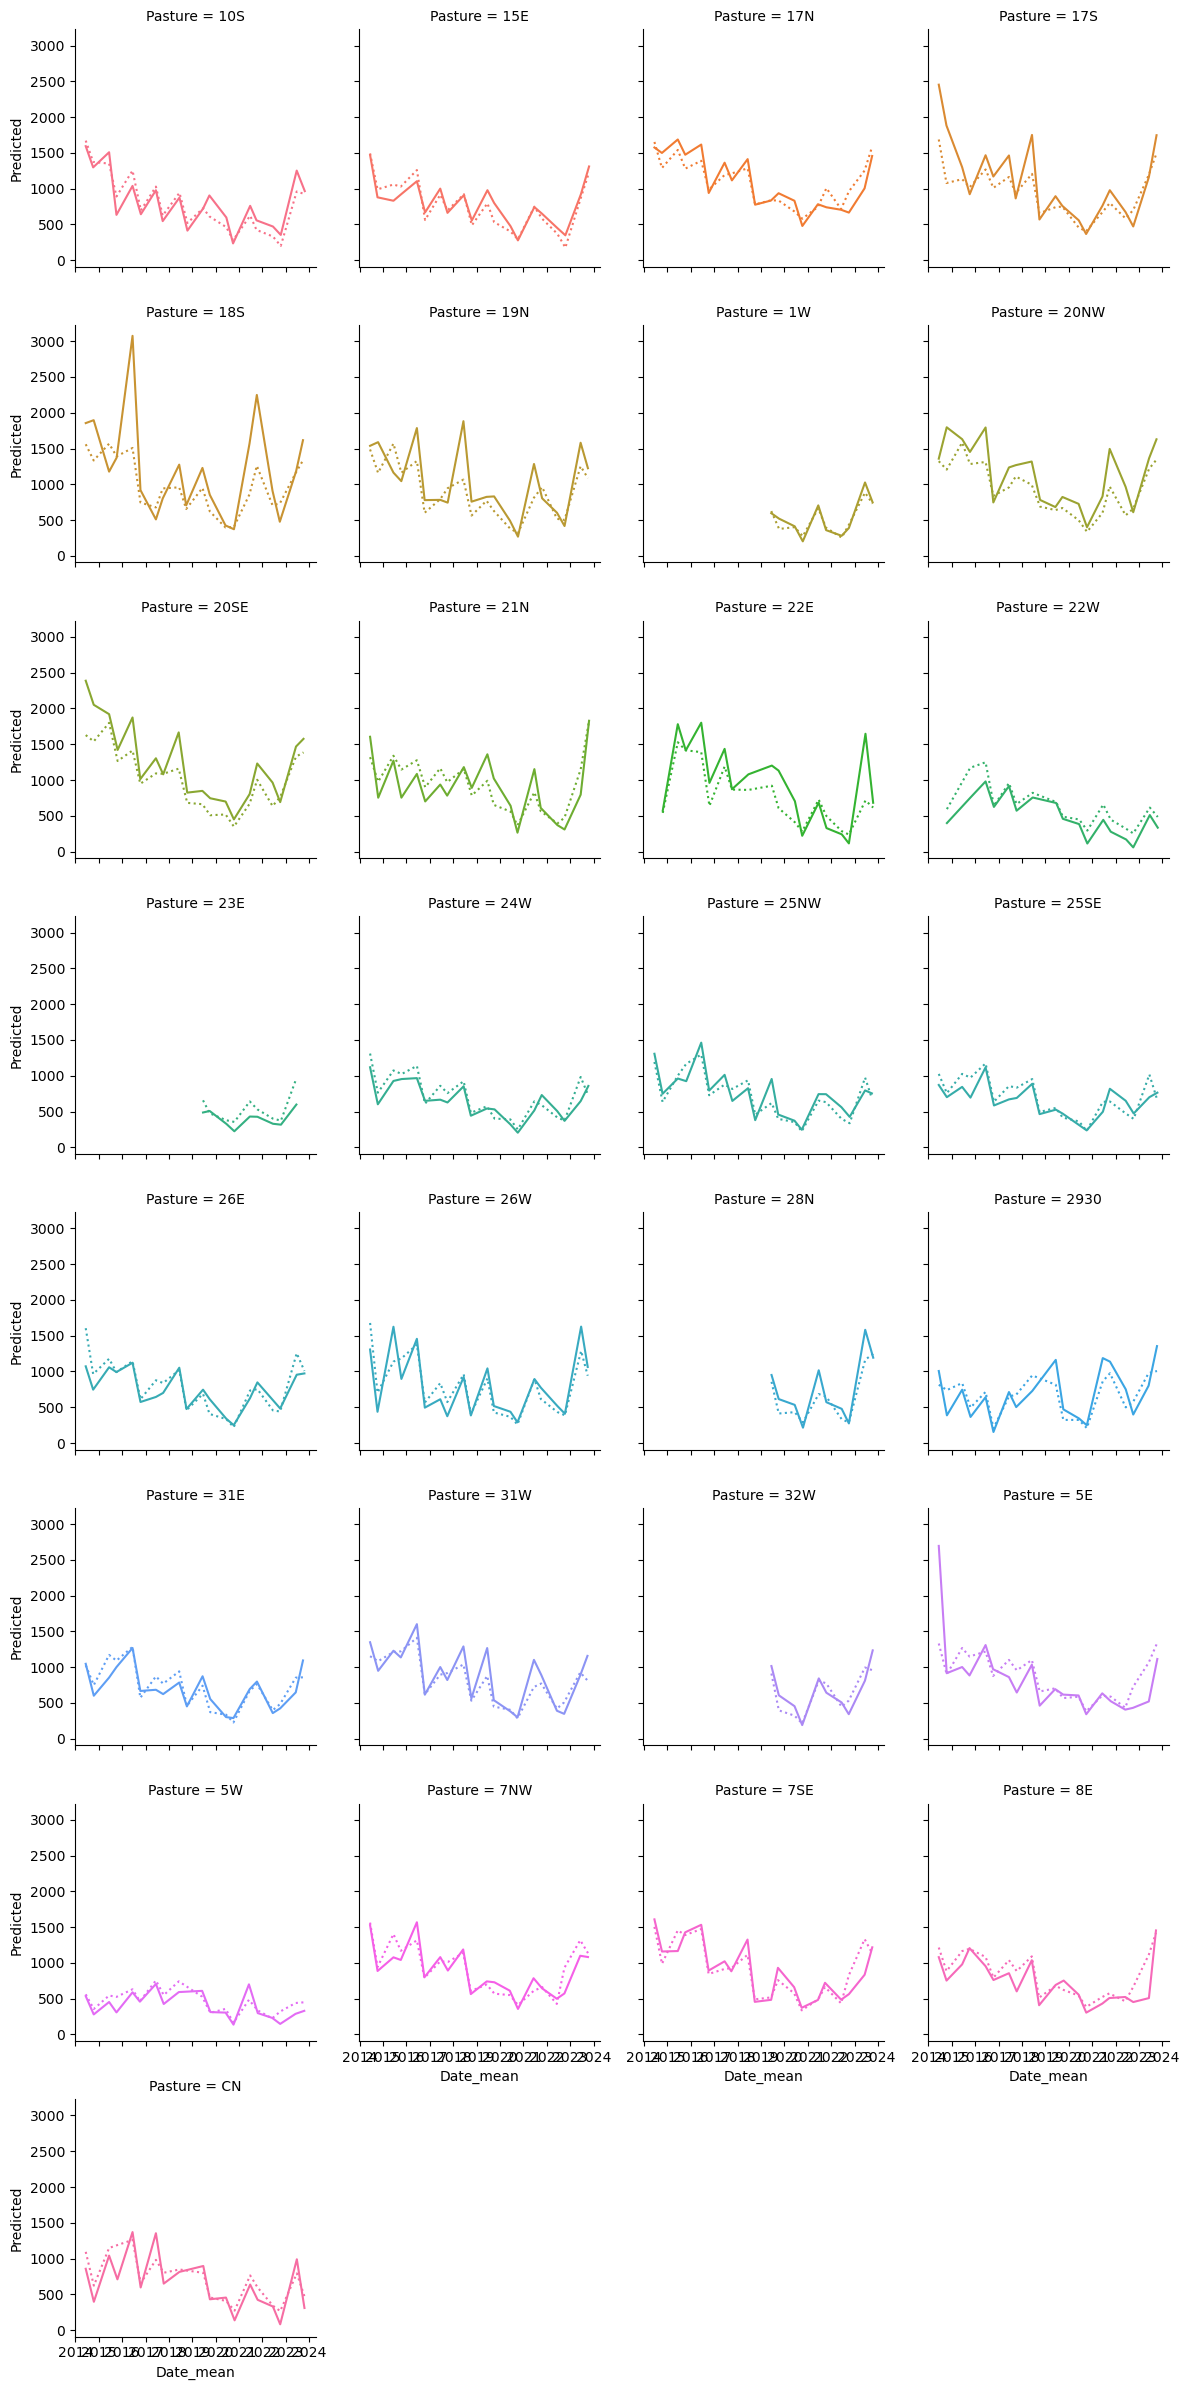

In [34]:
df_bm_pred[date_col] = pd.to_datetime(df_bm_pred[date_col])
df_bm_pred['DOY'] = df_bm_pred[date_col].dt.dayofyear
p_plot_ts_best = sns.FacetGrid(hue=past_col, 
                               data=df_bm_pred[df_bm_pred[mod_col] == 'PLS'].groupby(
                                   [past_col, 'DOY', date_col], 
                                   observed=True)[['Observed', 'Predicted']].mean().reset_index().sort_values([past_col, date_col]),
                               col=past_col, col_wrap=4, sharex=True)
p_plot_ts_best.map(plt.plot, date_col, 'Observed', linestyle='solid')
p_plot_ts_best.map(plt.plot, date_col, 'Predicted', linestyle='dotted')

### Pasture

In [35]:
mae_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])),
                                                      include_groups=False).mean(), 
    include_groups=False).round(4)
bias_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
        include_groups=False).mean(), include_groups=False).round(4)
mae_bt_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
        include_groups=False).mean(), include_groups=False).round(4)
bias_bt_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
        include_groups=False).mean(), include_groups=False).round(4)
r2_pasture = df_bm_pred.groupby([mod_col, past_col, logo_group] + group_cols, 
                                observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby([mod_col, logo_group],
                                                                                                                observed=True).apply(
    lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
    include_groups=False).round(4)
r2_corr_pasture = df_bm_pred.groupby([mod_col, past_col, logo_group] + group_cols,
                                     observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby([mod_col, logo_group],
                                                                                          observed=True).apply(
    lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
    include_groups=False).round(4)

In [36]:
df_smry_pasture = pd.DataFrame({
    'MAE': mae_pasture.unstack(level=0).mean().round(4),
    'MAE_std': mae_pasture.unstack(level=0).std().round(4),
    'Bias': bias_pasture.unstack(level=0).mean().round(4),
    'Bias_std': bias_pasture.unstack(level=0).std().round(4),
    'R^2': r2_pasture.unstack(level=0).mean().round(4),
    'R^2_std': r2_pasture.unstack(level=0).std().round(4),
    'r': r2_corr_pasture.unstack(level=0).mean().round(4),
    'r_std': r2_corr_pasture.unstack(level=0).std().round(4),
    'MAE_bt': mae_bt_pasture.unstack(level=0).mean().round(4),
    'MAE_bt_std': mae_bt_pasture.unstack(level=0).std().round(4),
    'MAE_bt_pct': (mae_bt_pasture / df_bm_pred.groupby([mod_col, past_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).mean().round(4),
    'MAE_bt_pct_std': (mae_bt_pasture / df_bm_pred.groupby([mod_col, past_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).std().round(4),
    'Bias_bt': bias_bt_pasture.unstack(level=0).mean().round(4),
    'Bias_bt_std': bias_bt_pasture.unstack(level=0).std().round(4),
})
display(df_smry_pasture)
if save_results:
    df_smry_pasture.to_csv(os.path.join(outDIR,
                                     'tables/ml_models', 
                                     re.sub('tmp.csv', 'results_pasture.csv', os.path.basename(inPATH))))

df_smry_pasture_by_yr = pd.DataFrame({
    'MAE': mae_pasture.round(4),
    'Bias': bias_pasture.round(4),
    'MAE_bt': mae_bt_pasture.round(4),
    'MAE_pct': (mae_bt_pasture / df_bm_pred.groupby([mod_col, logo_group],
                                                    observed=True)['Observed'].mean()).round(4),
    'R^2': r2_pasture.round(4),
    'r': r2_corr_pasture.round(4)
})
#display(df_smry_pasture_by_yr.sort_values('r'))
if save_results:
    df_smry_pasture_by_yr.to_csv(os.path.join(outDIR,
                                     'tables/ml_models', 
                                     re.sub('tmp.csv', 'results_pasture_yrly.csv', os.path.basename(inPATH))))

MAE  MAE_std    Bias  Bias_std     R^2  R^2_std       r   r_std  \
Source                                                                          
CPER_2022  0.3281   0.0389  0.0287    0.1570 -0.1622   0.1999  0.2998  0.1086   
OLS_2022   3.7074   0.8268  0.1638    1.0436  0.1675   0.1303  0.4744  0.1183   
OLS        3.5096   0.8251  0.0890    0.5020  0.2093   0.1455  0.4732  0.1510   
LASSO      3.3108   0.8192  0.2440    0.4375  0.3125   0.1071  0.5727  0.0923   
PLS        3.4416   0.9482  0.2112    0.4706  0.2647   0.1487  0.5310  0.1348   
PCR        3.4348   0.9473  0.2556    0.4999  0.2692   0.1378  0.5281  0.1280   
SVR        3.4126   0.9094 -0.2900    0.3578  0.2658   0.1345  0.5268  0.1327   
RF         3.2686   0.9600  0.1947    0.9521  0.3328   0.1493  0.6006  0.1356   
HGBR       3.1778   0.8875  0.0799    0.2998  0.3583   0.1541  0.6018  0.1484   
ENS_LIN    3.3774   0.9023  0.2427    0.4462  0.2908   0.1232  0.5520  0.1125   
ENS_ML     3.1910   0.8836  0.0210    0.3130  0.3557   0.1363  0.6066  0.1379   
ENS_ALL    3.2554   0.8774  0.1406    0.2532  0.3361   0.1243  0.5899  0.1232   

             MAE_bt  MAE_bt_std  MAE_bt_pct  MAE_bt_pct_std  Bias_bt  \
Source                                                                 
CPER_2022  270.6792    143.7621      0.3367          0.0839 -44.2351   
OLS_2022   221.5532    104.4276      0.2845          0.0781 -17.0850   
OLS        211.6363    100.3364      0.2685          0.0667 -25.7869   
LASSO      201.4756    101.5465      0.2533          0.0621 -11.7847   
PLS        209.7584    109.0210      0.2607          0.0651 -14.4532   
PCR        209.3042    108.4885      0.2602          0.0644 -11.0896   
SVR        208.5831    106.7156      0.2603          0.0650 -45.6040   
RF         199.4591    108.4668      0.2476          0.0664 -25.0192   
HGBR       194.3297    101.5220      0.2425          0.0625 -24.8316   
ENS_LIN    205.8238    105.9980      0.2565          0.0630 -12.4425   
ENS_ML     195.1489    101.5447      0.2433          0.0622 -31.8182   
ENS_ALL    198.4267    102.0481      0.2476          0.0618 -22.1304   

           Bias_bt_std  
Source                  
CPER_2022     126.4806  
OLS_2022       56.4049  
OLS            33.0727  
LASSO          32.2465  
PLS            31.4552  
PCR            30.1831  
SVR            29.6701  
RF             71.7033  
HGBR           19.5071  
ENS_LIN        29.9873  
ENS_ML         26.9870  
ENS_ALL        15.4938

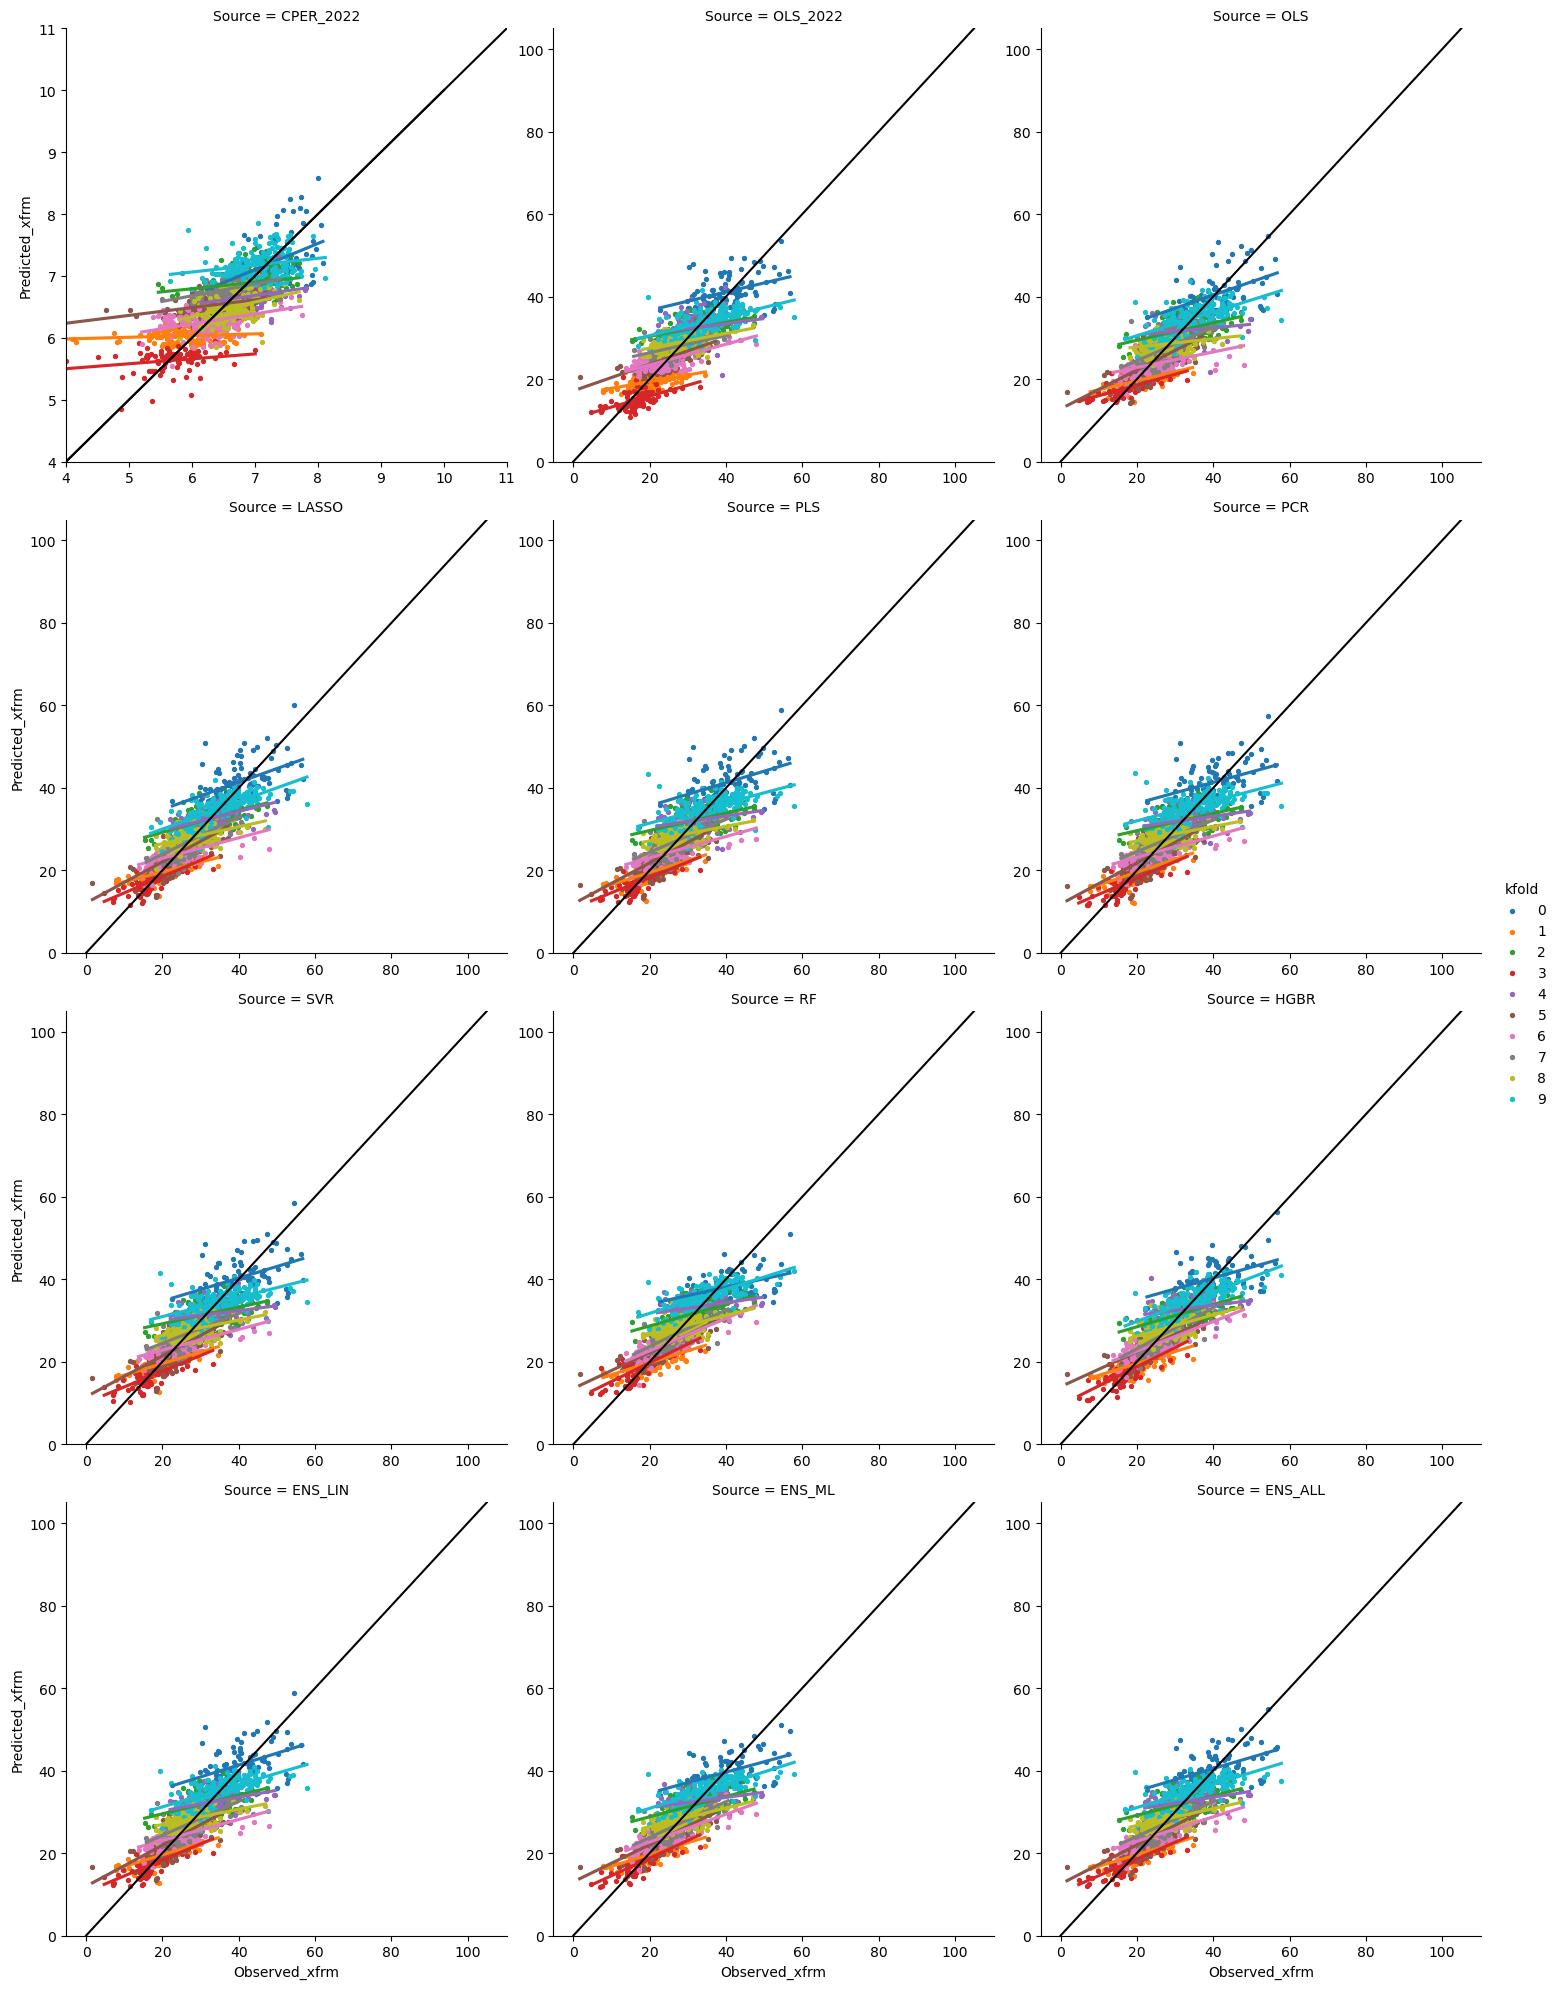

In [37]:
p_past = sns.lmplot(df_bm_pred.groupby(list(set([mod_col, logo_group, past_col] + group_cols)),
                                      observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                    facet_kws=dict(sharey=False, sharex=False,),
                    hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_past.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_past.axes[0].set_ylim((4, 11))
p_past.axes[0].set_xlim((4, 11))
p_past.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 
                             'figures/ml_models', 
                             re.sub('tmp.csv', 'results_pasture.png', os.path.basename(inPATH))), dpi=100)

## Extra plots (not currently used)

In [40]:
if 'Transect' in df_bm_pred.columns:
    p_trans = sns.lmplot(df_bm_pred, x='Observed', y='Predicted', col='Source', col_wrap=3, hue='Year', ci=None,
                         scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
    for ax in p_trans.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
    if save_results:
        plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)
else:
    p_trans=None

In [41]:
p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Year', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

/local/scratch/sean.kearney/16107206/ipykernel_2918297/3509725408.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
p_pasture = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Year', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Season', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_pasture_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean', 'Season']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Season', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture_seas.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

## Make variable importance dataframes

In [39]:
df_ols = mod_dict['OLS']['formula_df']

In [40]:
df_ols['features'] = df_ols['formula'].apply(lambda x: [f for f in x.split(' ~ ')[-1].split(' + ') if ':' not in f])

In [41]:
from tqdm import tqdm
"""
Calculated weighted relative variable importance for each variable across model types
"""
# set max vars based on where cross-validated metrics stop improving
max_vars = 3

var_names = list(set(df_ols['features'].sum()))

# Calculate decomposed R^2, relative variable importance (RVI) and AIC weights
df_ols_feats_ptn = pd.DataFrame(columns=['kfold', 'features', 'formula', 'RVI', 'weight'])
for k in df_ols['kfold'].unique():
    print(k)
    df_ols_sub_tmp = df_ols[(df_ols['kfold'] == k) &
    (df_ols['numb_vars'] <= max_vars)].copy()
    min_aic = (df_ols_sub_tmp['AIC']*0.001).min()
    df_ols_sub_tmp['AICw'] = [np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)] / \
    np.sum([np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)])
    for f in tqdm(var_names):
        df_ols_sub_f = df_ols_sub_tmp[[f in n for n in df_ols_sub_tmp['formula']]]
        if len(df_ols_sub_f) == 0:
            continue
        else:
            for f_form in df_ols_sub_f['formula']:
                f_form_omitted = re.sub(f + ":[^\+]* \+ ", "",
                                        re.sub(" \+ " + f + ":[^\+]*", "",
                                               re.sub(" \+ " + f + ":.+?(?= |$)", "",
                                                      re.sub(" \+(?<=\+)[^\+]*:" + f, "",
                                                             re.sub("\+ " + f + " (?=\+)", "",
                                                                    re.sub("(?<=~ )" + f + " \+ ", "",
                                                                           f_form))))))

                # print(f_form)
                # print(f_form_omitted)
                RVI_tmp = df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                OVI_tmp = df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                weight_tmp = df_ols_sub_tmp['AICw'][(df_ols_sub_tmp['formula'] == f_form)].values

                df_ols_feats_tmp = pd.DataFrame(dict(kfold=k,
                                                     features=f,
                                                     formula=f_form,
                                                     RVI=np.mean(RVI_tmp),
                                                     weight=weight_tmp),
                                                index=[0])
                df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])

2014


  0%|          | 0/28 [00:00<?, ?it/s]/local/scratch/sean.kearney/16301936/ipykernel_438907/2421960830.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])
100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


2015


100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


2016


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


2017


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


2018


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


2019


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


2020


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


2021


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


2022


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


2023


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


In [42]:
def feature_type(f):
    if f in ['RED', 'GREEN', 'BLUE', 'NIR', 'SWIR1', 'SWIR2']:
        return 'Band'
    elif 'BAI' in f:
        return 'BAI'
    else:
        return 'Veg. Index'

# calculate weighted relative variable importance (RVIw)
df_ols_feats_ptn['RVIw'] = df_ols_feats_ptn['RVI'] * df_ols_feats_ptn['weight']

# add input variable group field
df_ols_feats_ptn['group'] = df_ols_feats_ptn['features'].apply(feature_type)

# calculate sorted mean RVIw for each feature after summing across each kfold
df_ols_feats_grp = df_ols_feats_ptn.groupby(['kfold',
                                             'features',
                                             'group'])['RVIw'].sum().reset_index()
df_ols_feats_grp['RVIw_norm'] = df_ols_feats_grp.groupby('kfold')['RVIw'].transform(lambda x: x / x.mean())
df_ols_feats_grp['RVIw_mean'] = df_ols_feats_grp.groupby(['features'])['RVIw'].transform('mean')
df_ols_feats_grp = df_ols_feats_grp.sort_values(['RVIw_mean'], ascending=False).reset_index(drop=True)

In [43]:
df_ols_feats_grp['kfold'] = df_ols_feats_grp['kfold'].astype('str')
if kfold_group == 'Year':
    df_ols_feats_grp['kfold'] = pd.Categorical(df_ols_feats_grp['kfold'], 
                                               [str(x) for x in range(min(df_ols_feats_grp['kfold'].astype(int)),
                                                                      max(df_ols_feats_grp['kfold'].astype(int))+1)])

In [44]:
df_lasso_coefs = mod_dict['LASSO']['variable_df']
df_lasso_coefs['kfold'] = pd.Categorical(df_lasso_coefs['kfold'], categories=df_lasso_coefs['kfold'].sort_values().unique())
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
df_lasso_coefs_ranked = df_lasso_coefs.groupby('Variable', observed=True)['Coef_abs'].mean().sort_values(ascending=False)
df_lasso_coefs['Variable'] = pd.Categorical(df_lasso_coefs['Variable'], categories=df_lasso_coefs_ranked.index.values)
df_lasso_coefs['Coef_norm'] = df_lasso_coefs.groupby('kfold', observed=True)['Coef_abs'].transform(lambda x: x / x.mean())

dfs_lasso = []
for k in df_lasso_coefs['kfold'].unique():
    dfs_lasso_tmp = pd.DataFrame(data={'Variable': df_ols_feats_grp['features'].unique()})
    dfs_lasso_tmp['kfold'] = k
    dfs_lasso.append(dfs_lasso_tmp)
df_lasso_coefs_all = pd.concat(dfs_lasso)
df_lasso_coefs_all['Coef_abs_sum'] = 0.0
for k in df_lasso_coefs_all['kfold'].unique(): 
    for i in df_lasso_coefs_all['Variable']:
        df_lasso_coefs_all.loc[(df_lasso_coefs_all['Variable'] == i) & 
        (df_lasso_coefs_all['kfold'] == k),
        'Coef_abs_sum'] = df_lasso_coefs[df_lasso_coefs['kfold'] == k][[i in x for x in df_lasso_coefs[df_lasso_coefs['kfold'] == k]['Variable']]]['Coef_abs'].sum()
df_lasso_coefs_all['kfold'] = pd.Categorical(df_lasso_coefs_all['kfold'], categories=df_lasso_coefs_all['kfold'].sort_values().unique())
df_lasso_coefs_ranked = df_lasso_coefs_all.groupby('Variable', observed=True)['Coef_abs_sum'].mean().sort_values(ascending=False)
df_lasso_coefs_all['Variable'] = pd.Categorical(df_lasso_coefs_all['Variable'], categories=df_lasso_coefs_ranked.index.values)
df_lasso_coefs_all['Coef_norm'] = df_lasso_coefs_all.groupby('kfold', observed=True)['Coef_abs_sum'].transform(lambda x: x / x.mean()) 

In [45]:
df_pls_coefs = mod_dict['PLS']['variable_df']
df_pls_coefs['kfold'] = pd.Categorical(df_pls_coefs['kfold'], categories=df_pls_coefs['kfold'].sort_values().unique())
df_pls_coefs_ranked = df_pls_coefs.groupby('Variable', observed=True)['VIP'].mean().sort_values(ascending=False)
df_pls_coefs['Variable'] = pd.Categorical(df_pls_coefs['Variable'], categories=df_pls_coefs_ranked.index.values)
df_pls_coefs_top = df_pls_coefs[df_pls_coefs['VIP'] > 1.0].copy()
df_pls_coefs_top['Variable'] = df_pls_coefs_top['Variable'].cat.remove_unused_categories()

In [46]:
df_pcr_coefs = mod_dict['PCR']['variable_df']
df_pcr_coefs['kfold'] = pd.Categorical(df_pcr_coefs['kfold'], categories=df_pcr_coefs['kfold'].sort_values().unique())
pcr_coefs_abs_mean = df_pcr_coefs.groupby(['kfold', 'Variable'], observed=True).apply(lambda x: np.mean(np.abs(x), axis=1),
                                                                                     include_groups=False)
pcr_coefs_abs_mean.name = 'Coef_mean_abs'
df_pcr_coefs_mean = pcr_coefs_abs_mean.reset_index()

df_pcr_coefs_mean['Coef_mean_norm'] = df_pcr_coefs_mean.groupby('kfold', observed=True)['Coef_mean_abs'].transform(lambda x: x / x.mean())
pcr_vars_mean_ranked = df_pcr_coefs_mean.groupby('Variable', observed=True)['Coef_mean_abs'].mean().sort_values(ascending=False)
df_pcr_coefs_mean['Variable'] = pd.Categorical(df_pcr_coefs_mean['Variable'], categories=pcr_vars_mean_ranked.index.values)

df_pcr_coefs_mean_top20 = df_pcr_coefs_mean[df_pcr_coefs_mean['Variable'].isin(pcr_vars_mean_ranked.head(20).index.values)].copy()
df_pcr_coefs_mean_top20['Variable'] = df_pcr_coefs_mean_top20['Variable'].cat.remove_unused_categories()

In [47]:
df_svr_wts = mod_dict['SVR']['variable_df'].copy()
df_svr_wts['kfold'] = pd.Categorical(df_svr_wts['kfold'], categories=df_svr_wts['kfold'].sort_values().unique())
df_svr_wts['SVR_weights_abs'] = df_svr_wts['SVR_weights'].transform(lambda x: abs(x))
df_svr_wts['SVR_weights_norm'] = df_svr_wts.groupby('kfold', observed=True)['SVR_weights_abs'].transform(lambda x: x / x.mean())
df_svr_wts_ranked = df_svr_wts.groupby('Variable', observed=True)['SVR_weights_abs'].mean().sort_values(ascending=False)
df_svr_wts['Variable'] = pd.Categorical(df_svr_wts['Variable'], categories=df_svr_wts_ranked.index.values)

In [48]:
df_rf_mdi = mod_dict['RF']['variable_df'].copy()
df_rf_mdi['kfold'] = pd.Categorical(df_rf_mdi['kfold'], categories=df_rf_mdi['kfold'].sort_values().unique())
df_rf_mdi['MDI_norm'] = df_rf_mdi.groupby('kfold', observed=True)['MDI'].transform(lambda x: x / x.mean())
df_rf_mdi_ranked = df_rf_mdi.groupby('Variable', observed=True)['MDI_norm'].mean().sort_values(ascending=False)
df_rf_mdi['Variable'] = pd.Categorical(df_rf_mdi['Variable'], categories=df_rf_mdi_ranked.index.values)

In [49]:
#df_gbr_mdi = mod_dict['GBR']['variable_df'].copy()
#df_gbr_mdi['kfold'] = pd.Categorical(df_gbr_mdi['kfold'], categories=df_gbr_mdi['kfold'].sort_values().unique())
#df_gbr_mdi['MDI_norm'] = df_gbr_mdi.groupby('kfold', observed=True)['MDI'].transform(lambda x: x / x.mean())
#df_gbr_mdi_ranked = df_gbr_mdi.groupby('Variable', observed=True)['MDI_norm'].mean().sort_values(ascending=False)
#df_gbr_mdi['Variable'] = pd.Categorical(df_gbr_mdi['Variable'], categories=df_gbr_mdi_ranked.index.values)

In [50]:
df_hgbr_pi = mod_dict['HGBR']['variable_df'].copy()
df_hgbr_pi['kfold'] = pd.Categorical(df_hgbr_pi['kfold'], categories=df_hgbr_pi['kfold'].sort_values().unique())
df_hgbr_pi['PI_norm'] = df_hgbr_pi.groupby('kfold', observed=True)['PI'].transform(lambda x: x / x.mean())
df_hgbr_pi_ranked = df_hgbr_pi.groupby('Variable', observed=True)['PI_norm'].mean().sort_values(ascending=False)
df_hgbr_pi['Variable'] = pd.Categorical(df_hgbr_pi['Variable'], categories=df_hgbr_pi_ranked.index.values)

In [51]:
df_ols_feats_grp['Model'] = 'OLS'
df_ols_feats_grp['VI'] = df_ols_feats_grp['RVIw_norm']
df_ols_feats_grp['Variable'] = df_ols_feats_grp['features']

df_lasso_coefs_all['Model'] = 'LASSO'
df_lasso_coefs_all['VI'] = df_lasso_coefs_all['Coef_norm']

df_pls_coefs['Model'] = 'PLS'
df_pls_coefs['VI'] = df_pls_coefs['VIP']

df_pcr_coefs_mean['Model'] = 'PCR'
df_pcr_coefs_mean['VI'] = df_pcr_coefs_mean['Coef_mean_norm']

df_svr_wts['Model'] = 'SVR'
df_svr_wts['VI'] = df_svr_wts['SVR_weights_norm']

df_rf_mdi['Model'] = 'RF'
df_rf_mdi['VI'] = df_rf_mdi['MDI_norm']

#df_gbr_mdi['Model'] = 'GBR'
#df_gbr_mdi['VI'] = df_gbr_mdi['MDI_norm']

df_hgbr_pi['Model'] = 'HGBR'
df_hgbr_pi['VI'] = df_hgbr_pi['PI_norm']

vi_cols_list = ['Model','kfold', 'Variable', 'VI']

df_vi_all = pd.concat([df_lasso_coefs_all[vi_cols_list],
                       df_pls_coefs[vi_cols_list],
                       df_pcr_coefs_mean[vi_cols_list],
                       df_svr_wts[vi_cols_list],
                       df_rf_mdi[vi_cols_list],
                       #df_gbr_mdi[vi_cols_list],
                       df_hgbr_pi[vi_cols_list]])
df_vi_all = df_vi_all.reset_index(drop=True)

### Variable importance plots

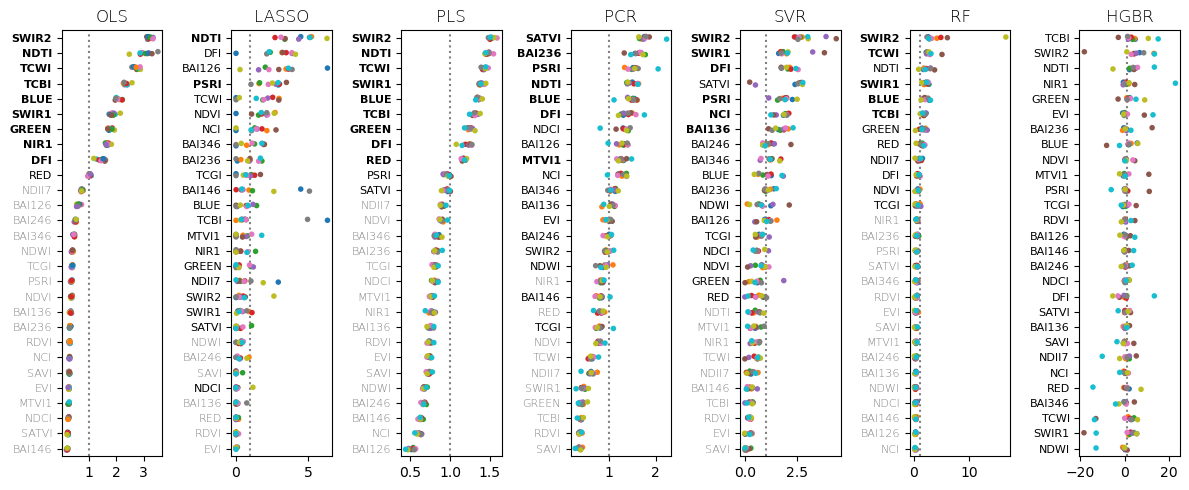

In [54]:
fig, axs = plt.subplots(ncols=7, nrows=1, figsize=(12, 5), 
                        sharex=False, sharey=False)
for idx, df_tmp in enumerate([df_ols_feats_grp,
                              df_lasso_coefs_all,
                              df_pls_coefs,
                              df_pcr_coefs_mean,
                              df_svr_wts,
                              df_rf_mdi,
                              df_hgbr_pi]):
    df_tmp['Variable'] = df_tmp['Variable'].apply(lambda x: re.sub('_', '', x))
    #top_vars = [x for x in df_tmp['Variable'].unique() if df_tmp[df_tmp['Variable'] == x]['VI'].mean() >= 1.0]
    top_vars = [x for x in df_tmp['Variable'].unique() if np.all(df_tmp[df_tmp['Variable'] == x]['VI'] >= 1.0)]
    #bottom_vars = [x for x in df_tmp['Variable'].unique() if df_tmp[df_tmp['Variable'] == x]['VI'].mean() < 1.0]
    bottom_vars = [x for x in df_tmp['Variable'].unique() if np.all(df_tmp[df_tmp['Variable'] == x]['VI'] < 1.0)]
    sns.stripplot(y='Variable', x='VI', data=df_tmp, size=4,
                  hue='kfold', orient='h',
                  ax=axs.flatten()[idx], legend=False)
    for ytick in axs.flatten()[idx].get_yticklabels():
        if ytick.get_text() in top_vars:
            ytick.set_fontweight(800)
        elif ytick.get_text() in bottom_vars:
            ytick.set_fontweight(100)
            ytick.set_color('grey')
    axs.flatten()[idx].yaxis.set_tick_params(labelsize=8)
    axs.flatten()[idx].axvline(x=1.0, linestyle='dotted', color='grey')
    axs.flatten()[idx].set_title(df_tmp['Model'].unique()[0], fontweight=10)
    #if idx > 3:
    #    axs.flatten()[idx].set_xlabel('Variable importance')
    #else:
    axs.flatten()[idx].set_xlabel(None)
    axs.flatten()[idx].set_ylabel(None)
plt.tight_layout()
if save_results:
    plt.savefig(os.path.join(outDIR, 
                             'figures/ml_models', 
                             re.sub('tmp.csv', 'vi_all.png', os.path.basename(inPATH))), dpi=100)

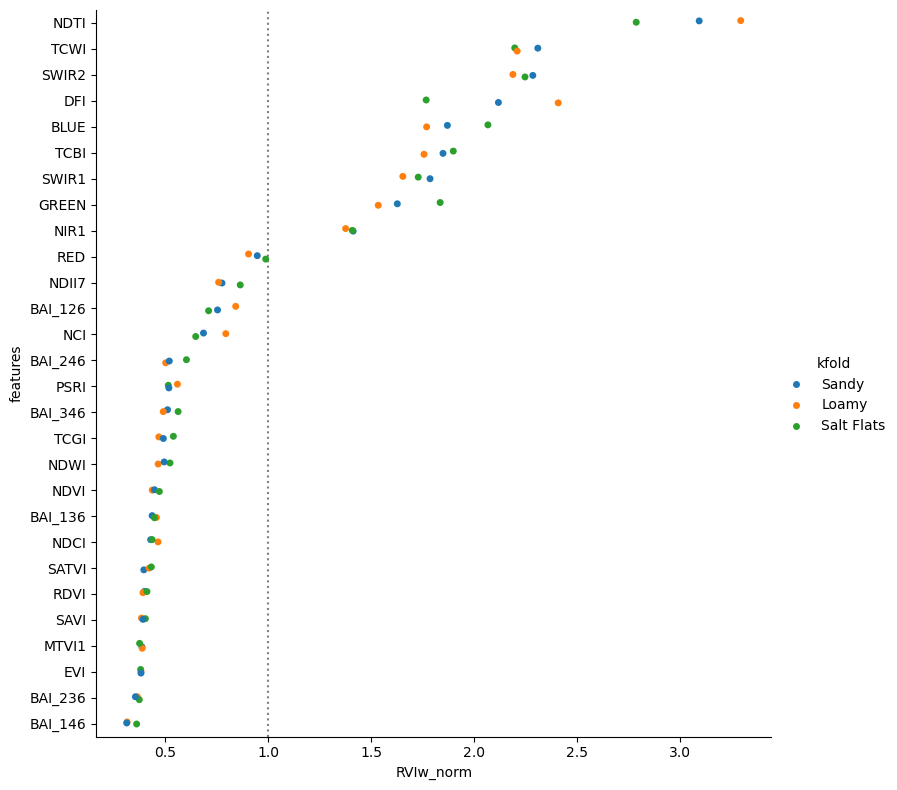

In [86]:
p = sns.catplot(y='features', x='RVIw_norm', hue='kfold',# hue_order=['Band', 'Veg. Index', 'BAI'],
                orient='h',# palette=sns.color_palette()[6:-1],
                data=df_ols_feats_grp,
                height=8, aspect=1.0)
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
#if save_results:
#    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_ols.png', os.path.basename(inPATH))), dpi=100)

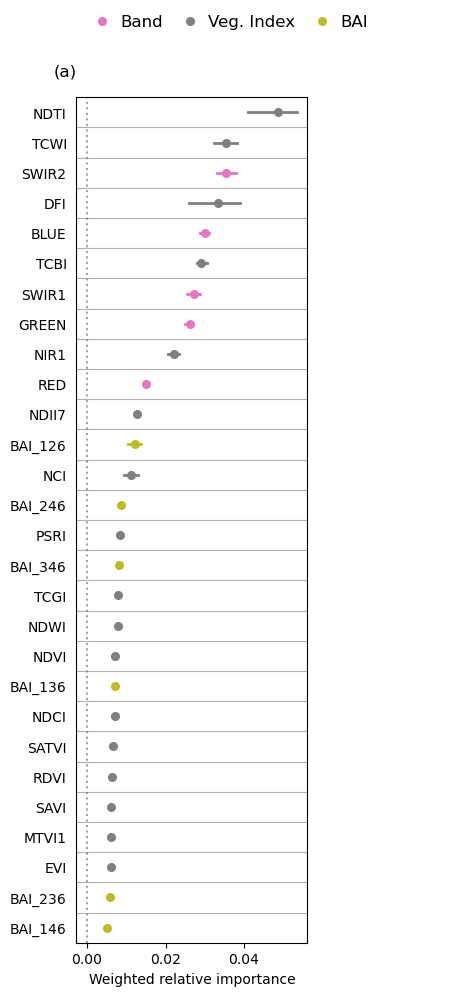

In [87]:
"""
Figure 2: Plot variable importance calculated from all model subsets
"""
font_sml = 10
font_med=12
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(1, 2, 1)
pplot1 = sns.pointplot(y='features', x='RVIw', hue='group', hue_order=['Band', 'Veg. Index', 'BAI'],
                       orient='h', dodge=False, ax=ax1, linestyles='None', linewidth=2.0,
                       palette=sns.color_palette()[6:-1],
                       err_kws=dict(linewidth=2.0),
                       data=df_ols_feats_grp)
ax1.set_ylabel('')
ax1.set_xlabel('Weighted relative importance', fontsize=font_sml)
ax1.get_legend().remove()
#ax1.set_xlim((-0.10, 0.50))
ax1.set_yticks(np.arange(0.5, len(df_ols_feats_grp['features'].unique()) - 1, 1), minor=True)
ax1.grid(which='minor', axis='y')
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
for tic in ax1.yaxis.get_minor_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
ax1.axvline(x=0, color='grey', alpha=0.75, linestyle='dotted')
ax1.tick_params(axis='x', which='major', labelsize=font_sml)
ax1.tick_params(axis='y', which='major', labelsize=font_sml)
ax1.text(x=-0.1, y=1.025, s='(a)', transform=ax1.transAxes, size=font_med)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=font_med,
           columnspacing=0.6, handletextpad=0.1, frameon=False)
plt.tight_layout(w_pad=3.0, rect=(0, 0, 1, 0.95))
if save_results:
    plt.savefig(outDIR_figs + mod_dir_dict[mod_type] + mod_type + '_variable_importance.png', dpi=600,
                bbox_inches='tight', pad_inches=0.2)
    plt.close()

In [ ]:
p = sns.catplot(df_lasso_coefs_all, x='Coef_norm', y='Variable', hue='kfold', height=8, aspect=1.0, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
#for ax in p.axes.flatten():
#    ax.tick_params(axis='x', rotation=90)

In [ ]:
p = sns.catplot(df_pls_coefs, x='VIP', y='Variable',  hue='kfold', height=8, aspect=1.0, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')

In [ ]:
p = sns.catplot(df_pcr_coefs_mean,
                x='Coef_mean_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')

In [ ]:
p = sns.catplot(df_svr_wts,
                x='SVR_weights_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_svr.png', os.path.basename(inPATH))), dpi=100)

In [94]:
df_svr_wts.groupby('Variable', observed=True)['SVR_weights_norm'].mean()

Variable
SWIR2      3.248787
SWIR1      2.497594
BAI_136    1.827635
NCI        1.629908
NDVI       1.508274
DFI        1.335951
NDWI       1.319505
BAI_346    1.346744
GREEN      1.211063
BLUE       1.172355
PSRI       1.150184
NDCI       1.038067
BAI_126    1.055384
SATVI      0.929783
BAI_236    0.834357
NDTI       0.819090
TCGI       0.726233
BAI_246    0.652782
BAI_146    0.590613
EVI        0.525799
NDII7      0.511270
TCWI       0.523419
RED        0.451092
RDVI       0.442271
SAVI       0.302825
MTVI1      0.130662
NIR1       0.113749
TCBI       0.104606
Name: SVR_weights_norm, dtype: float64

In [ ]:
p = sns.catplot(df_rf_mdi,
                x='MDI_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_rf.png', os.path.basename(inPATH))), dpi=100)

In [ ]:
p = sns.catplot(df_gbr_mdi,
                x='MDI_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_gbr.png', os.path.basename(inPATH))), dpi=100)

## Make parameter tuning dataframes

In [55]:
param_dfs = {}
for k in mod_dict:
    if 'tune_results' in mod_dict[k].keys():
        for idx, kfold in enumerate(mod_dict[k]['tune_results']):
            if idx == 0:
                param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results'][kfold]['params']]))
                #param_dfs[k] = pd.DataFrame(columns=['Model', 'kfold', 'Best', 'MAE'] + param_names)
            df_tmp = pd.DataFrame({'Model': k,
                                   'kfold': str(kfold),
                                   'Best': 0,
                                   'MAE': mod_dict[k]['tune_results'][kfold]['mean_test_MAE'],
                                   #'R2': mod_dict[k]['tune_results'][kfold]['mean_test_R2'],
                                   #'R2_train': mod_dict[k]['tune_results'][kfold]['mean_train_R2']
                                  })
            for p in param_names:
                df_tmp[p] = mod_dict[k]['tune_results'][kfold]['param_' + p].data
            idx_best = mod_dict[k]['tune_results'][kfold]['rank_test_MAE'].argmin()
            df_tmp.loc[idx_best, 'Best'] = 1
            if idx == 0:
                param_dfs[k] = df_tmp
            else:
                param_dfs[k] = pd.concat([param_dfs[k], df_tmp.dropna(how='all', axis=0)])
        if k in param_dfs.keys():
            param_dfs[k] = param_dfs[k].reset_index(drop=True)

In [113]:
param_dfs['PCR']

Model kfold  Best       MAE pca__n_components
0     PCR  2014     0 -5.987544                 1
1     PCR  2014     0 -5.208924                 2
2     PCR  2014     0 -4.376159                 3
3     PCR  2014     0 -4.349545                 4
4     PCR  2014     0 -4.304866                 5
..    ...   ...   ...       ...               ...
125   PCR  2023     0 -4.247566                 9
126   PCR  2023     0 -4.168809                10
127   PCR  2023     1 -4.105374                11
128   PCR  2023     0 -4.107210                12
129   PCR  2023     0 -4.105788                13

[130 rows x 5 columns]

In [134]:
param_dict = {
    'LASSO_1': 'LASSO__alpha',
    'PLS_1': 'PLS__n_components',
    'PCR_1': 'pca__n_components',
    'SVR_1': 'SVR__C',
    'SVR_2': 'SVR__epsilon',
    'RF_1': 'RF__max_features',
    'RF_2': 'RF__max_samples',
    'RF_3': 'RF__min_samples_split',
    'RF_4': 'RF__n_estimators',
    'HGBR_5': 'GBR__learning_rate',
    'HGBR_6': 'GBR__max_features',
    'HGBR_7': 'GBR__min_samples_leaf'   
}

log_list = ['LASSO__alpha', 'SVR__C', 'SVR__epsilon', 'GRB__learning_rate']
drop_cols = ['Model', 'kfold', 'Best', 'MAE']

In [148]:
df_combos = pd.DataFrame(columns=['Model', 'unique_combos', 'max_combos', 'possible_combos'])
for idx, ks in enumerate(['LASSO', 'PCR', 'PLS', 'SVR', 'RF', 'HGBR']):
    combos_all_tmp = param_dfs[ks][[c for c in param_dfs[ks].columns if c not in drop_cols]].astype(str).apply(
        lambda x: '_'.join(x), axis=1).unique()
    df_tmp = param_dfs[ks][param_dfs[ks]['Best'] == 1]
    combos_tmp = df_tmp[[c for c in df_tmp.columns if c not in drop_cols]].astype(str).apply(
        lambda x: '_'.join(x), axis=1)
    df_combos = pd.concat([df_combos,
                          pd.DataFrame({'Model': ks,
                                        'unique_combos': len(combos_tmp.unique()),
                                        'max_combos': max(combos_tmp.value_counts()),
                                        'possible_combos': len(combos_all_tmp)}, index=[idx])])

In [149]:
df_combos

Model unique_combos max_combos possible_combos
0  LASSO             7          3              30
1    PCR             2          9              13
2    PLS             2          6              13
3    SVR             5          4              15
4     RF             6          4              96
5   HGBR             4          3              45

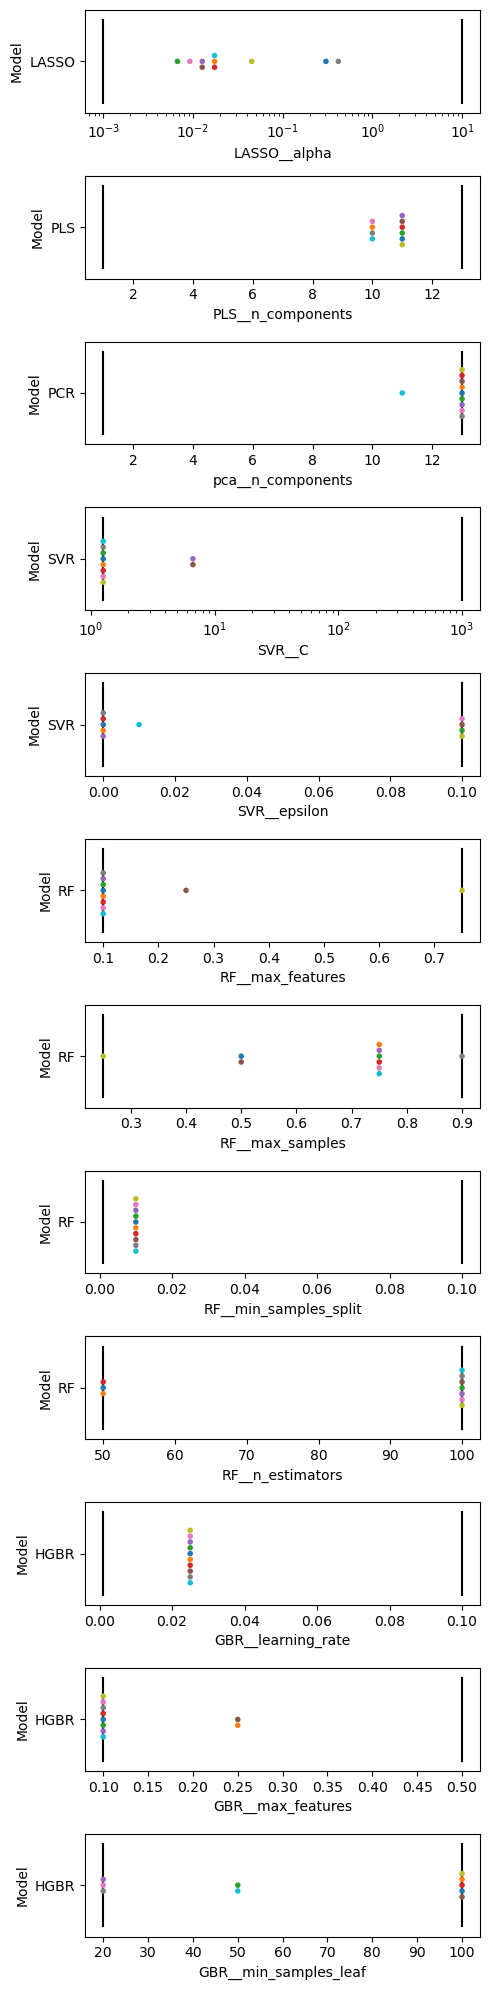

In [128]:
fig, axs = plt.subplots(nrows=len(param_dict.keys()), figsize=(5, 20))
for idx, k in enumerate(param_dict.keys()):
    ks = k.split('_')[0]
    if param_dict[k] in log_list:
        log_val = 10
    else:
        log_val = None
    sns.swarmplot(y='Model', x=param_dict[k], data=param_dfs[ks][param_dfs[ks]['Best'] == 1],
                  size=4,
                  hue='kfold',
                  orient='h',
                  legend=False,
                  ax=axs[idx],
                  log_scale=log_val
                 )
    axs[idx].axvline(x=param_dfs[ks][param_dict[k]].min(), ymin=0.1, ymax=0.9, color='black')
    axs[idx].axvline(x=param_dfs[ks][param_dict[k]].max(), ymin=0.1, ymax=0.9, color='black')
fig.tight_layout()

In [ ]:
sns.swarmplot(y='Model', x='LASSO__alpha', data=param_dfs['LASSO'][param_dfs['LASSO']['Best'] == 1],
              size=4,
              hue='kfold',
              orient='h',
              legend=False,
              ax=axs[0],
              log_scale=10
             )
axs[0].axvline(x=param_dfs['LASSO']['LASSO__alpha'].min(), ymin=0.1, ymax=0.9, color='black')
axs[0].axvline(x=param_dfs['LASSO']['LASSO__alpha'].max(), ymin=0.1, ymax=0.9, color='black')
#axs[0].set_xlim(-1, param_dfs['LASSO']['LASSO__alpha'].max()*1.2)


sns.swarmplot(y='Model', x='PLS__n_components', data=param_dfs['PLS'][param_dfs['PLS']['Best'] == 1],
              size=4,
              hue='kfold',
              orient='h',
              legend=False,
              ax=axs[1]
             )
axs[1].axvline(x=param_dfs['PLS']['PLS__n_components'].min(), ymin=0.1, ymax=0.9, color='black')
axs[1].axvline(x=param_dfs['PLS']['PLS__n_components'].max(), ymin=0.1, ymax=0.9, color='black')
#axs[0].set_xlim(-1, param_dfs['PLS']['PLS__n_components'].max()*1.2)

fig.tight_layout()

In [57]:
param_dfs['LASSO'][param_dfs['LASSO']['Best'] == 1]

Model kfold  Best       MAE LASSO__alpha
18   LASSO  2014     1 -4.142827      0.30392
39   LASSO  2015     1 -4.169643     0.017433
66   LASSO  2016     1 -4.239205     0.006723
99   LASSO  2017     1 -4.245733     0.017433
128  LASSO  2018     1 -4.278226      0.01269
158  LASSO  2019     1 -4.205008      0.01269
187  LASSO  2020     1 -4.408323     0.009237
229  LASSO  2021     1 -4.251044     0.417532
252  LASSO  2022     1 -4.218210     0.045204
279  LASSO  2023     1 -4.176098     0.017433

## Plot parameter tuning

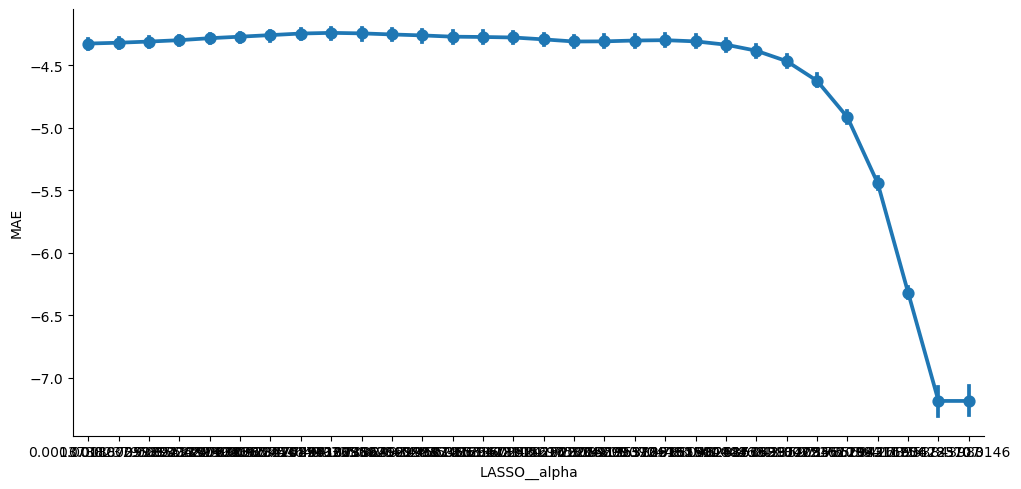

In [105]:
sns.catplot(x='LASSO__alpha', y='MAE', data=param_dfs['LASSO'], hue='kfold', kind='point', aspect=2)

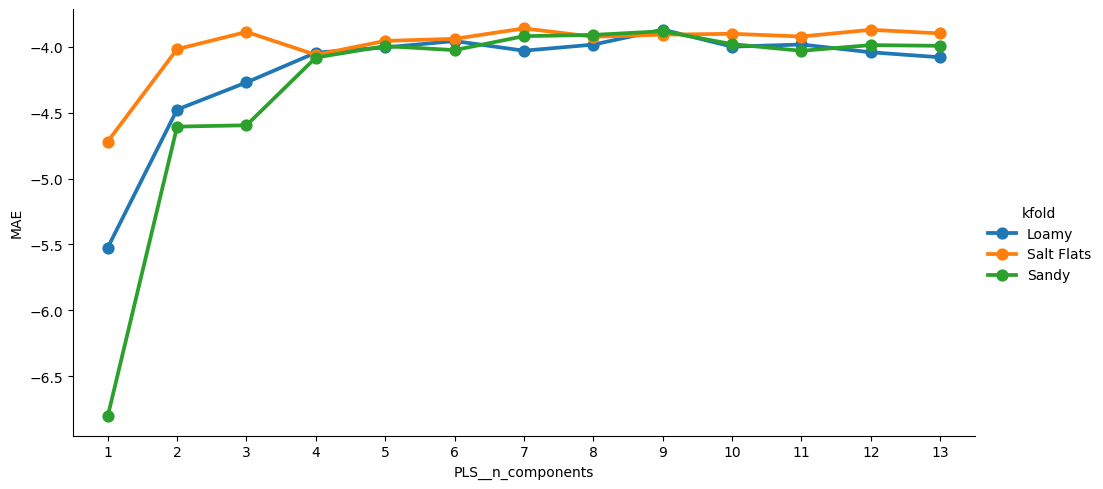

In [102]:
sns.catplot(x='PLS__n_components', y='MAE', data=param_dfs['PLS'], hue='kfold', kind='point', aspect=2)

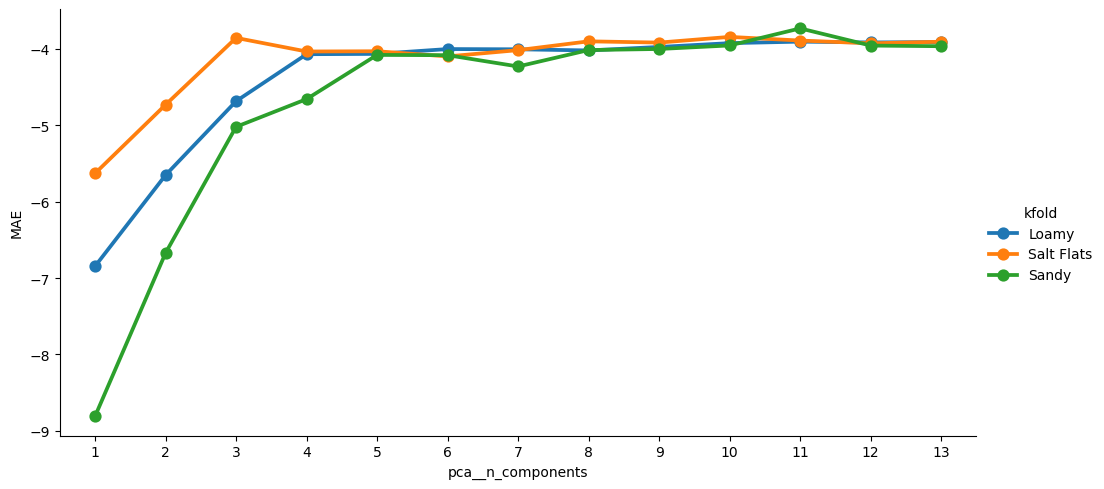

In [103]:
sns.catplot(x='pca__n_components', y='MAE', data=param_dfs['PCR'], hue='kfold', kind='point', aspect=2)

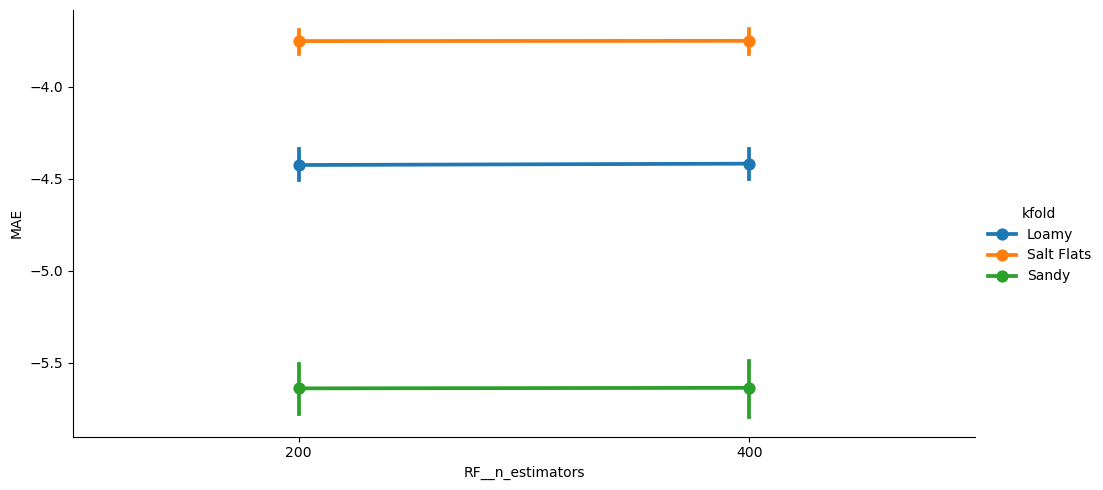

In [104]:
sns.catplot(x='RF__n_estimators', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

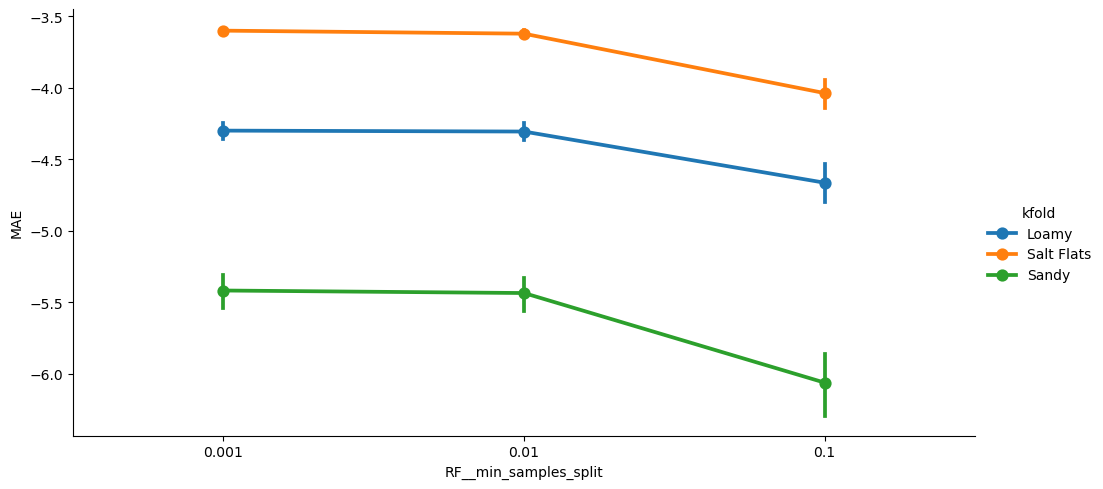

In [105]:
sns.catplot(x='RF__min_samples_split', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

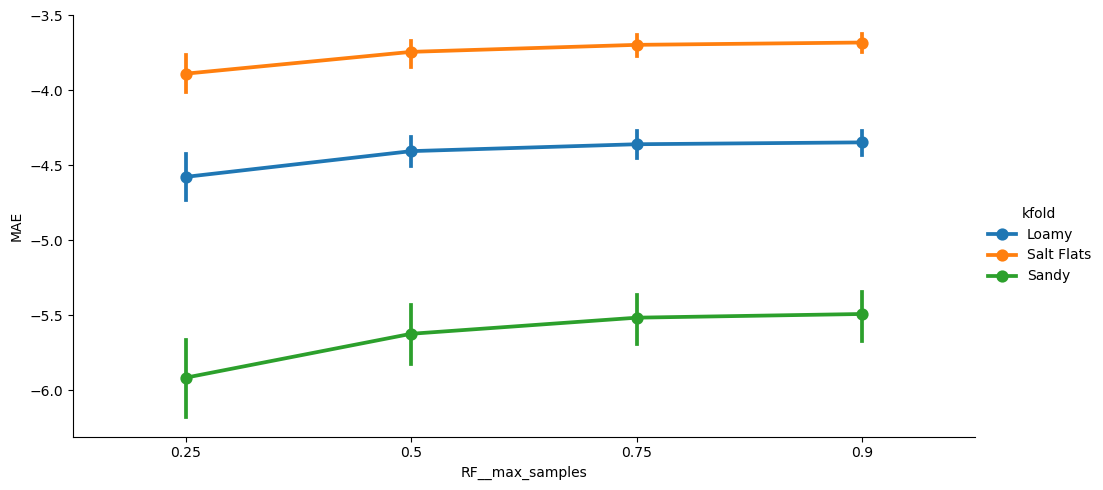

In [106]:
sns.catplot(x='RF__max_samples', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

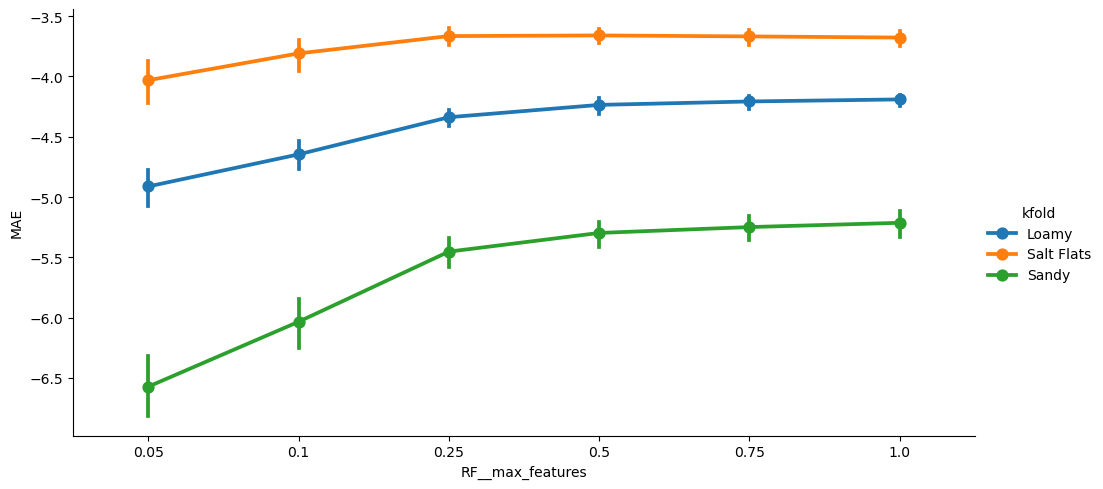

In [107]:
sns.catplot(x='RF__max_features', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

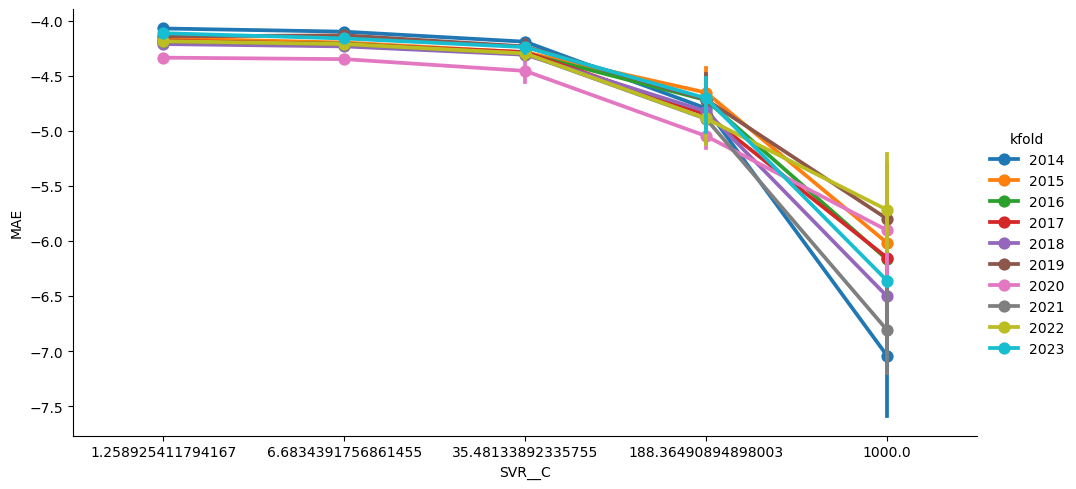

In [34]:
sns.catplot(x='SVR__C', y='MAE', data=param_dfs['SVR'], hue='kfold', kind='point', aspect=2)

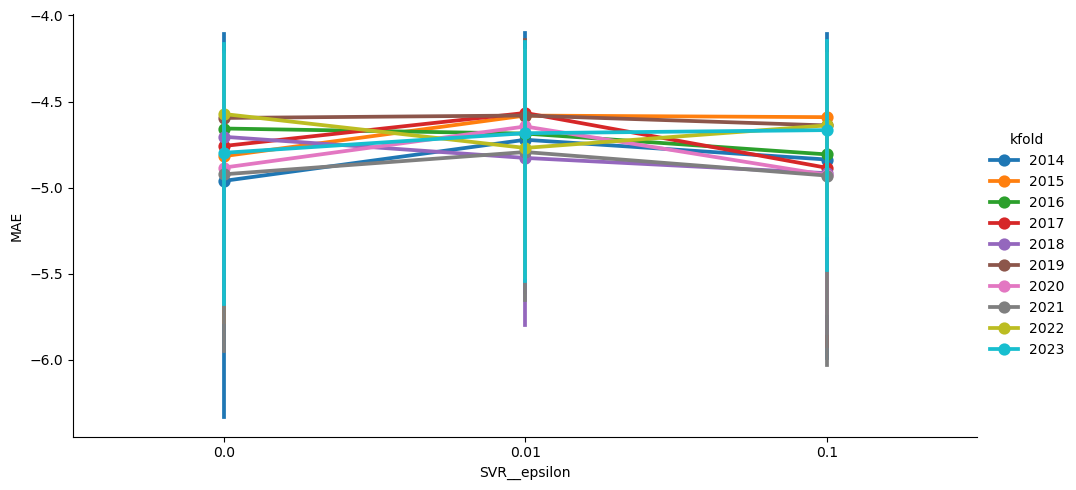

In [35]:
sns.catplot(x='SVR__epsilon', y='MAE', data=param_dfs['SVR'], hue='kfold', kind='point', aspect=2)

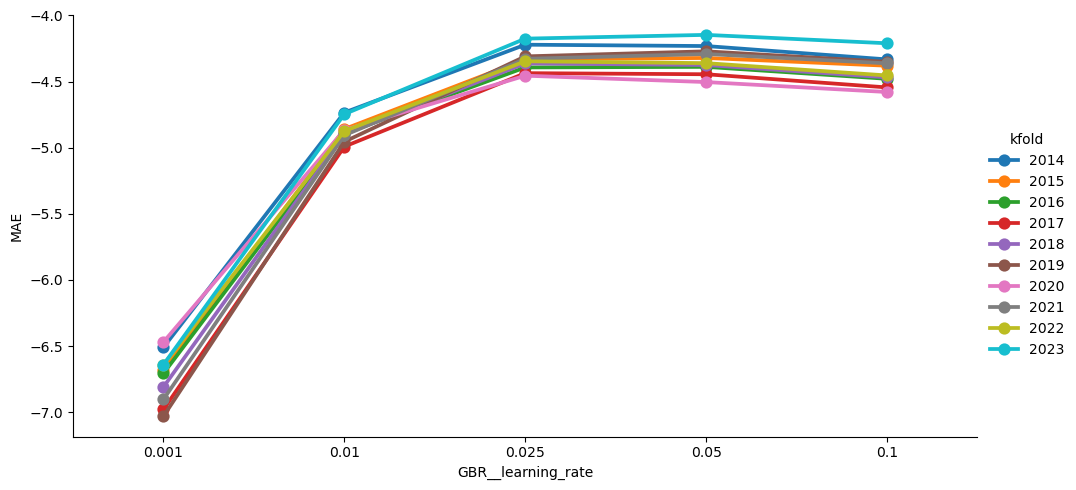

In [36]:
sns.catplot(x='GBR__learning_rate', y='MAE', data=param_dfs['HGBR'], hue='kfold', kind='point', aspect=2)

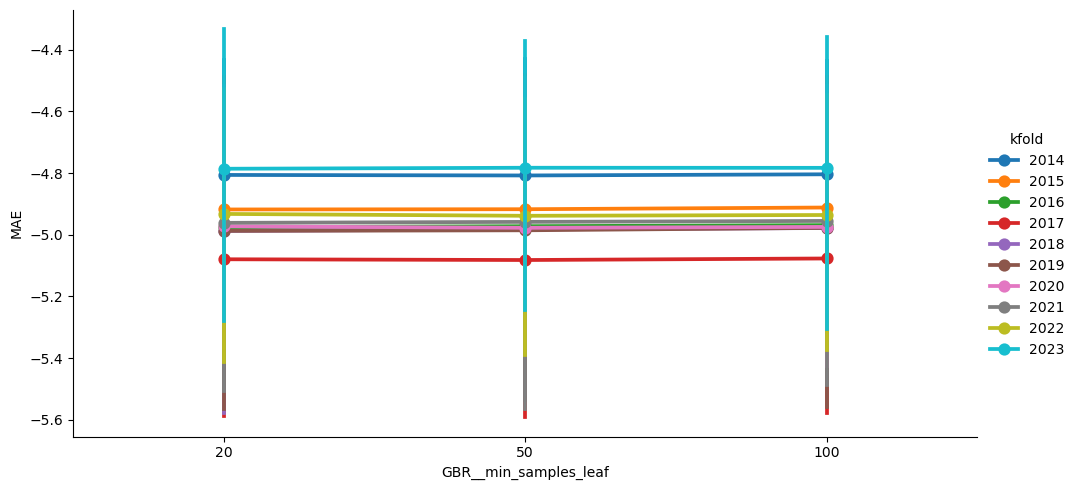

In [37]:
sns.catplot(x='GBR__min_samples_leaf', y='MAE', data=param_dfs['HGBR'], hue='kfold', kind='point', aspect=2)

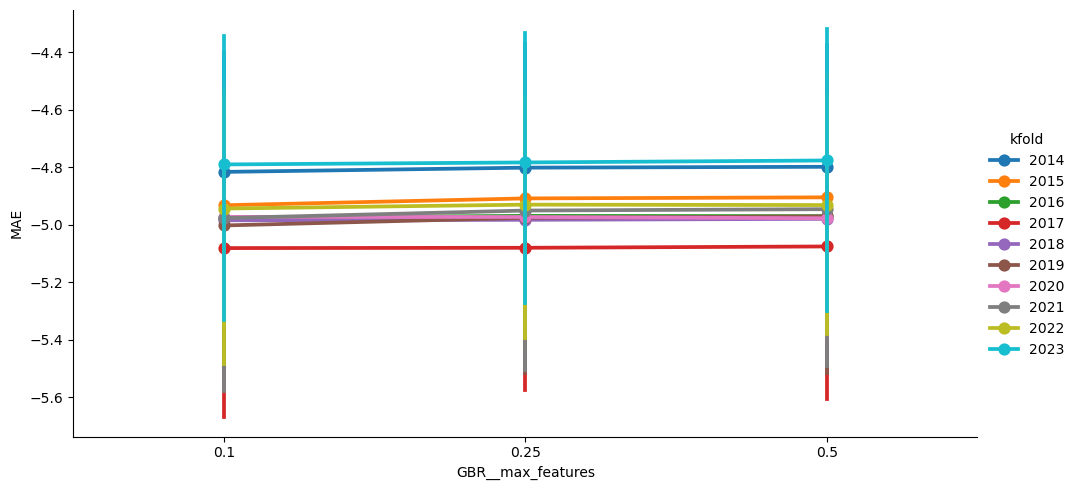

In [38]:
sns.catplot(x='GBR__max_features', y='MAE', data=param_dfs['HGBR'], hue='kfold', kind='point', aspect=2)

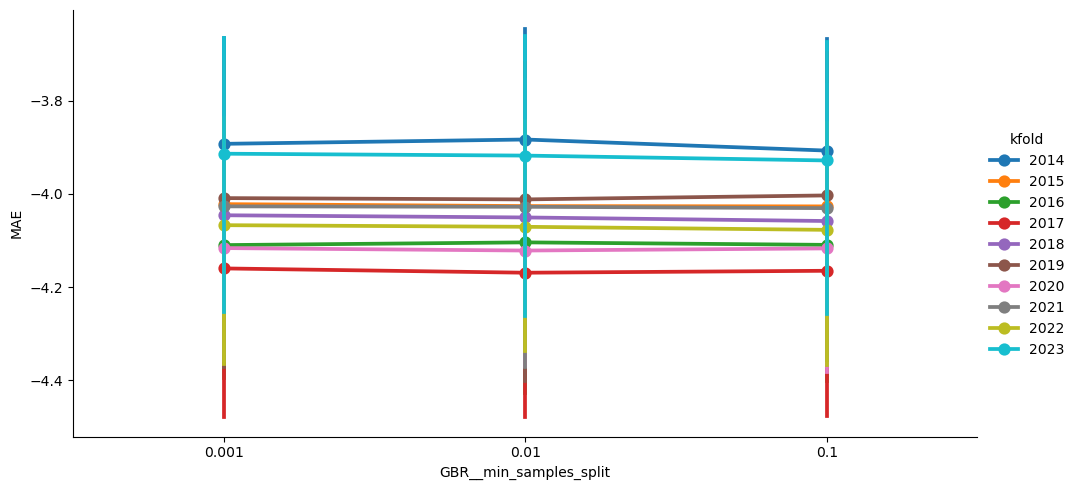

In [114]:
sns.catplot(x='GBR__min_samples_split', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

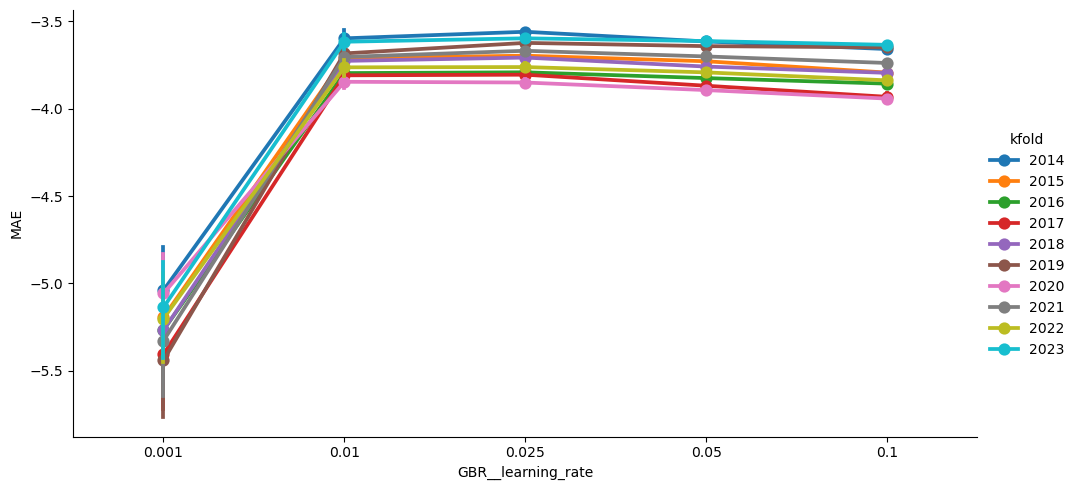

In [115]:
sns.catplot(x='GBR__learning_rate', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

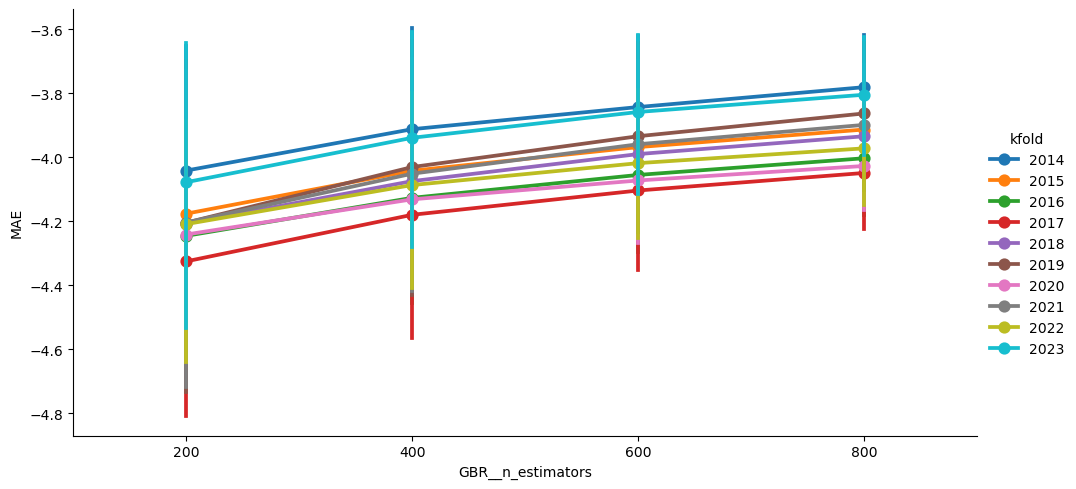

In [116]:
sns.catplot(x='GBR__n_estimators', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

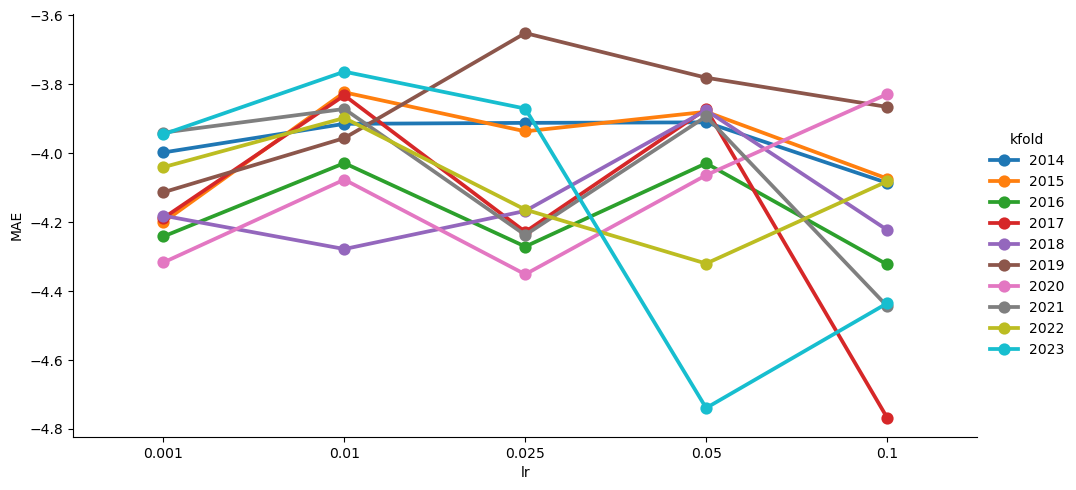

In [118]:
sns.catplot(x='lr', y='MAE', data=param_dfs['DNN'], hue='kfold', kind='point', aspect=2)